In [2]:
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, MaxPooling1D,
    Dropout, Flatten, Dense, LSTM, GRU
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
import joblib
import xgboost as xgb
from tensorflow.keras import regularizers

# Define features and target
features = ['gr','dt','dt_nct','rhob_combined','res_deep','hp','ob']
target_col = 'ppp'
depth_col = 'depth'
files = ['C:\Geo\QAZIAN -1X.CSV','C:\Geo\MISSA KESWAL-01.CSV','C:\Geo\MISSA KESWAL-03.CSV']

def detect_delimiter(fp):
    with open(fp,'r') as f:
        return csv.Sniffer().sniff(f.readline()).delimiter

# Load & clean data
dfs = []
for fp in files:
    delim = detect_delimiter(fp)
    df = pd.read_csv(fp, delimiter=delim, engine='python')
    df.columns = df.columns.str.strip().str.lower()
    df.replace(-999.25, np.nan, inplace=True)
    df = df[features + [target_col, depth_col]].dropna()
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Split data
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

X_train = train_df[features].values
y_train = train_df[target_col].values
X_test  = test_df[features].values
y_test  = test_df[target_col].values

# Scale data
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# Reshape for CNN
X_train_cnn = X_train_s.reshape(-1, len(features), 1)
X_test_cnn  = X_test_s.reshape(-1, len(features), 1)

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Evaluation function
def evaluate(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    rel  = rmse/(y_true.max()-y_true.min())*100
    print(f"{name}: R²={r2:.4f}, RMSE={rmse:.2f}, MAE={mae:.2f}, RelRMSE={rel:.2f}%")

# --- Train CNN ---
print("Training CNN...")
cnn = Sequential([
        Input((len(features),1)),
        
        # First Conv Block with regularization
        Conv1D(64, kernel_size=2, padding='same', activation='relu',
               kernel_regularizer=regularizers.L2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),  # Slightly lower dropout after conv layers
        
        # Second Conv Block  
        Conv1D(128, kernel_size=2, padding='same', activation='relu',
               kernel_regularizer=regularizers.L2(0.001)),
        BatchNormalization(),
        Dropout(0.25),
        
        Flatten(),
        
        # Dense layers with stronger regularization
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.L2(0.002)),  
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu',                       
              kernel_regularizer=regularizers.L2(0.002)),
        BatchNormalization(), 
        Dropout(0.3),
        
        Dense(1)  # Output layer (no regularization needed)
    ])

cnn.compile(optimizer='adam', loss='mse')
cnn.fit(X_train_cnn, y_train,
        validation_split=0.2,
        epochs=100, batch_size=32,
        callbacks=[es, rlr],
        verbose=1)
cnn.save('cnn_model_nosphi.h5')
y_pred_cnn = cnn.predict(X_test_cnn).flatten()
evaluate("CNN", y_test, y_pred_cnn)

# --- Train DFNN ---
print("\nTraining DFNN...")
dfnn = Sequential([
    Dense(256, activation='relu', input_shape=(len(features),)),  
    BatchNormalization(),
    Dropout(0.2),  # Lower dropout for tabular data
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1)  # Single output for regression
])
dfnn.compile(optimizer='adam', loss='mse')
dfnn.fit(X_train_s, y_train,
         validation_split=0.3,
         epochs=100, batch_size=32,
         callbacks=[es, rlr],
         verbose=1)
dfnn.save('dfnn_model_nosphi.h5')
y_pred_dfnn = dfnn.predict(X_test_s).flatten()
evaluate("DFNN", y_test, y_pred_dfnn)

# --- Train RNN ---
print("\nTraining RNN...")
# Reshape for RNN
X_train_rnn = X_train_s.reshape(-1, len(features), 1)
X_test_rnn = X_test_s.reshape(-1, len(features), 1)

def create_simple_rnn():
    model = Sequential([
        Input((len(features), 1)),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1)
    ])
    return model

rnn = create_simple_rnn()
rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])
rnn.fit(X_train_rnn, y_train,
        validation_split=0.2,
        epochs=150,
        batch_size=16,
        callbacks=[es, rlr],
        verbose=1)
rnn.save('rnn_model_nosphi.h5')
y_pred_rnn = rnn.predict(X_test_rnn).flatten()
evaluate("RNN", y_test, y_pred_rnn)

# --- Train Random Forest ---
print("\nTraining Random Forest...")
rf = RandomForestRegressor(
    n_estimators=500, max_depth=15,
    min_samples_split=5, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)
rf.fit(X_train_s, y_train)
joblib.dump(rf, 'rf_model_nosphi.pkl')
y_pred_rf = rf.predict(X_test_s)
evaluate("Random Forest", y_test, y_pred_rf)

# --- Train XGBoost ---
print("\nTraining XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10
)
xgb_model.fit(
    X_train_s, y_train,
    eval_set=[(X_test_s, y_test)],
    verbose=False
)
xgb_model.save_model('xgb_model_nosphi.json')
y_pred_xgb = xgb_model.predict(X_test_s)
evaluate("XGBoost", y_test, y_pred_xgb)

print("\n✅ All models trained and saved successfully!")
print("\nTraining Set Results Summary:")
evaluate("CNN", y_test, y_pred_cnn)
evaluate("DFNN", y_test, y_pred_dfnn)
evaluate("RNN", y_test, y_pred_rnn)
evaluate("Random Forest", y_test, y_pred_rf)
evaluate("XGBoost", y_test, y_pred_xgb)

Training CNN...
Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 9959352.0000 - val_loss: 9814997.0000 - learning_rate: 0.0010
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9712753.0000 - val_loss: 9331990.0000 - learning_rate: 0.0010
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 9122117.0000 - val_loss: 8602547.0000 - learning_rate: 0.0010
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 8448635.0000 - val_loss: 7665430.0000 - learning_rate: 0.0010
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 7443783.0000 - val_loss: 6775480.5000 - learning_rate: 0.0010
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 6440235.5000 - val_loss: 5854440.0000 - learning_rate: 0.0010
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 5593079.0000 - val_loss: 4987064.5000 - learning_rate: 0.0010
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4657394.0000 - val_loss: 3966492.0000 - learning_rate: 

210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
CNN: R²=0.8361, RMSE=386.45, MAE=260.69, RelRMSE=7.32%

Training DFNN...


C:\Users\rohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 9928225.0000 - val_loss: 9870184.0000 - learning_rate: 0.0010
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9848239.0000 - val_loss: 9387741.0000 - learning_rate: 0.0010
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9215146.0000 - val_loss: 8753711.0000 - learning_rate: 0.0010
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 8549716.0000 - val_loss: 8079278.0000 - learning_rate: 0.0010
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 7875458.0000 - val_loss: 7107102.5000 - learning_rate: 0.0010
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7006137.5000 - val_loss: 6299095.0000 - learning_rate: 0.0010
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6216884.0000 - val_loss: 5724840.5000 - learning_rate: 0.0010
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5367079.5000 - val_loss: 4686587.0000 - learning_rate: 0.0010
Epoch 9/100
34

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
DFNN: R²=0.8359, RMSE=386.69, MAE=261.26, RelRMSE=7.33%

Training RNN...
Epoch 1/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 10011317.0000 - mae: 3017.9802 - val_loss: 9524227.0000 - val_mae: 2956.3206 - learning_rate: 0.0010
Epoch 2/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 9108939.0000 - mae: 2891.8574 - val_loss: 7891990.5000 - val_mae: 2719.3574 - learning_rate: 0.0010
Epoch 3/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 7426192.5000 - mae: 2629.7314 - val_loss: 6408148.5000 - val_mae: 2469.5234 - learning_rate: 0.0010
Epoch 4/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 5436511.0000 - mae: 2252.7209 - val_loss: 4010814.7500 - val_mae: 1949.0909 - learning_rate: 0.0010
Epoch 5/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 3640976.2500 - mae: 1825.0262 - val_loss: 2590695.2500 - val_mae: 1536.9673 - learning_rate: 0.0010
Epoch 6/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 2215678

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RNN: R²=0.8666, RMSE=348.57, MAE=227.10, RelRMSE=6.60%

Training Random Forest...
Random Forest: R²=0.9933, RMSE=78.36, MAE=36.34, RelRMSE=1.48%

Training XGBoost...
XGBoost: R²=0.9937, RMSE=75.70, MAE=44.38, RelRMSE=1.43%

✅ All models trained and saved successfully!

Training Set Results Summary:
CNN: R²=0.8361, RMSE=386.45, MAE=260.69, RelRMSE=7.32%
DFNN: R²=0.8359, RMSE=386.69, MAE=261.26, RelRMSE=7.33%
RNN: R²=0.8666, RMSE=348.57, MAE=227.10, RelRMSE=6.60%
Random Forest: R²=0.9933, RMSE=78.36, MAE=36.34, RelRMSE=1.48%
XGBoost: R²=0.9937, RMSE=75.70, MAE=44.38, RelRMSE=1.43%


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
import joblib
import xgboost as xgb

# Load blind well data
blind_file = 'C:\Geo\MISSA KESWAL-02.CSV'
df = pd.read_csv(blind_file, delimiter=',')
df.columns = df.columns.str.strip().str.lower()
df.replace(-999.25, np.nan, inplace=True)

features = ['gr', 'dt', 'dt_nct', 'rhob_combined', 'res_deep', 'hp', 'ob']
depth_col = 'depth'
target_col = 'ppp'

df.dropna(subset=features + [depth_col, target_col], inplace=True)
df_finetune, df_val = train_test_split(df, test_size=0.85, random_state=42)
print(f"Fine-tune samples: {len(df_finetune)}, Validation samples: {len(df_val)}")

# Scale data
scaler = StandardScaler()
X_ft = scaler.fit_transform(df_finetune[features])
y_ft = df_finetune[target_col].values
X_val = scaler.transform(df_val[features])
y_val = df_val[target_col].values

# Reshape for CNN/RNN
X_ft_cnn = X_ft.reshape(-1, X_ft.shape[1], 1)
X_val_cnn = X_val.reshape(-1, X_val.shape[1], 1)

# Evaluation function
def eval_model(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    rel  = rmse/(y_true.max()-y_true.min())*100
    print(f"{name}: R²={r2:.4f}, RMSE={rmse:.2f}, MAE={mae:.2f}, RelRMSE={rel:.2f}%")

# Callbacks for fine-tuning
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

Fine-tune samples: 794, Validation samples: 4500


In [4]:
# Load original CNN model
cnn_original = load_model('cnn_model_nosphi.h5', compile=False)
cnn_original.compile(optimizer='adam', loss='mse')

# Test original model on blind well
y_pred_cnn_original = cnn_original.predict(X_val_cnn).flatten()

print("🔮 CNN Blind Well Results (Before Fine-tuning):")
eval_model("CNN Original", y_val, y_pred_cnn_original)

# Fine-tune CNN
cnn_f = clone_model(cnn_original)
cnn_f.set_weights(cnn_original.get_weights())
cnn_f.compile(optimizer='adam', loss='mse')

cnn_f.fit(X_ft_cnn, y_ft,
          validation_data=(X_val_cnn, y_val),
          epochs=100, batch_size=16,
          callbacks=[es, rlr], verbose=1)

# Test fine-tuned model
y_pred_cnn_finetuned = cnn_f.predict(X_val_cnn).flatten()

print("\n🔮 CNN Blind Well Results (After Fine-tuning):")
eval_model("CNN Fine-tuned", y_val, y_pred_cnn_finetuned)

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
🔮 CNN Blind Well Results (Before Fine-tuning):
CNN Original: R²=-0.9273, RMSE=1124.48, MAE=888.88, RelRMSE=28.30%
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1260180.7500 - val_loss: 756833.8750 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 961216.8750 - val_loss: 632807.9375 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 781041.1250 - val_loss: 562409.1875 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 761191.8125 - val_loss: 511248.2188 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 662705.1250 - val_loss: 464791.1250 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 605101.1875 - val_loss: 439483.4375 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 555132.5625 - val_loss: 400176.2812 - learning_rate: 0.0010
Epoc

In [5]:
# Load original DFNN model
dfnn_original = load_model('dfnn_model_nosphi.h5', compile=False)
dfnn_original.compile(optimizer='adam', loss='mse')

# Test original model on blind well
y_pred_dfnn_original = dfnn_original.predict(X_val).flatten()

print("🔮 DFNN Blind Well Results (Before Fine-tuning):")
eval_model("DFNN Original", y_val, y_pred_dfnn_original)

# Fine-tune DFNN
dfnn_f = clone_model(dfnn_original)
dfnn_f.set_weights(dfnn_original.get_weights())
dfnn_f.compile(optimizer='adam', loss='mse')

dfnn_f.fit(X_ft, y_ft,
           validation_data=(X_val, y_val),
           epochs=100, batch_size=16,
           callbacks=[es, rlr], verbose=1)

# Test fine-tuned model
y_pred_dfnn_finetuned = dfnn_f.predict(X_val).flatten()

print("\n🔮 DFNN Blind Well Results (After Fine-tuning):")
eval_model("DFNN Fine-tuned", y_val, y_pred_dfnn_finetuned)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔮 DFNN Blind Well Results (Before Fine-tuning):
DFNN Original: R²=-1.3093, RMSE=1230.89, MAE=914.04, RelRMSE=30.98%
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1434010.3750 - val_loss: 686281.3125 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 757361.8125 - val_loss: 561406.5625 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 734164.9375 - val_loss: 492804.3750 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 655885.2500 - val_loss: 459013.1250 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 555667.7500 - val_loss: 424206.4375 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 488023.6875 - val_loss: 382890.2500 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 559822.2500 - val_loss: 395677.0938 - learning_rate: 0.0010
Ep

In [6]:
# Reshape for RNN
X_ft_rnn = X_ft.reshape(-1, len(features), 1)
X_val_rnn = X_val.reshape(-1, len(features), 1)

# Load original RNN model
rnn_original = load_model('rnn_model_nosphi.h5', compile=False)
rnn_original.compile(optimizer='adam', loss='mse')

# Test original model on blind well
y_pred_rnn_original = rnn_original.predict(X_val_rnn).flatten()

print("🔮 RNN Blind Well Results (Before Fine-tuning):")
eval_model("RNN Original", y_val, y_pred_rnn_original)

# Fine-tune RNN
rnn_f = clone_model(rnn_original)
rnn_f.set_weights(rnn_original.get_weights())
rnn_f.compile(optimizer='adam', loss='mse')

rnn_f.fit(X_ft_rnn, y_ft,
          validation_data=(X_val_rnn, y_val),
          epochs=100, batch_size=16,
          callbacks=[es, rlr], verbose=1)

# Test fine-tuned model
y_pred_rnn_finetuned = rnn_f.predict(X_val_rnn).flatten()

print("\n🔮 RNN Blind Well Results (After Fine-tuning):")
eval_model("RNN Fine-tuned", y_val, y_pred_rnn_finetuned)

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
🔮 RNN Blind Well Results (Before Fine-tuning):
RNN Original: R²=-1.1118, RMSE=1177.08, MAE=948.35, RelRMSE=29.63%
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 1238992.5000 - val_loss: 852800.6250 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 949252.0625 - val_loss: 710119.5625 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 687113.5625 - val_loss: 642035.2500 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 671122.0000 - val_loss: 546102.1875 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 668164.0625 - val_loss: 545805.3125 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 564195.8125 - val_loss: 492885.9688 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 574279.2500 - val_loss: 470177.4375 - learning_rate: 0.0010
Epoc

In [7]:
# Load original RF model
rf_original = joblib.load('rf_model_nosphi.pkl')

# Test original model on blind well
y_pred_rf_original = rf_original.predict(X_val)

print("🔮 Random Forest Blind Well Results (Before Fine-tuning):")
eval_model("RF Original", y_val, y_pred_rf_original)

# Fine-tune RF (retrain on blind well samples)
rf_f = RandomForestRegressor(
    n_estimators=500, max_depth=15,
    min_samples_split=5, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)
rf_f.fit(X_ft, y_ft)

# Test fine-tuned model
y_pred_rf_finetuned = rf_f.predict(X_val)

print("\n🔮 Random Forest Blind Well Results (After Fine-tuning):")
eval_model("RF Fine-tuned", y_val, y_pred_rf_finetuned)

🔮 Random Forest Blind Well Results (Before Fine-tuning):
RF Original: R²=-1.2294, RMSE=1209.40, MAE=976.97, RelRMSE=30.44%

🔮 Random Forest Blind Well Results (After Fine-tuning):
RF Fine-tuned: R²=0.8883, RMSE=270.77, MAE=179.66, RelRMSE=6.81%


In [8]:
# Load original XGBoost model
xgb_original = xgb.XGBRegressor()
xgb_original.load_model('xgb_model_nosphi.json')

# Test original model on blind well
y_pred_xgb_original = xgb_original.predict(X_val)

print("🔮 XGBoost Blind Well Results (Before Fine-tuning):")
eval_model("XGBoost Original", y_val, y_pred_xgb_original)

# Fine-tune XGBoost
xgb_f = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10
)
xgb_f.fit(
    X_ft, y_ft,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Test fine-tuned model
y_pred_xgb_finetuned = xgb_f.predict(X_val)

print("\n🔮 XGBoost Blind Well Results (After Fine-tuning):")
eval_model("XGBoost Fine-tuned", y_val, y_pred_xgb_finetuned)

🔮 XGBoost Blind Well Results (Before Fine-tuning):
XGBoost Original: R²=-1.0037, RMSE=1146.55, MAE=928.36, RelRMSE=28.86%

🔮 XGBoost Blind Well Results (After Fine-tuning):
XGBoost Fine-tuned: R²=0.9350, RMSE=206.46, MAE=147.12, RelRMSE=5.20%


In [ ]:

print("="*60)
print("SUMMARY: Model Performance on Blind Well (85% validation set)")
print("="*60)

results = {
    'Model': ['CNN', 'DFNN', 'RNN', 'Random Forest', 'XGBoost'],
    'Before Fine-tuning': [
        r2_score(y_val, y_pred_cnn_original),
        r2_score(y_val, y_pred_dfnn_original),
        r2_score(y_val, y_pred_rnn_original),
        r2_score(y_val, y_pred_rf_original),
        r2_score(y_val, y_pred_xgb_original)
    ],
    'After Fine-tuning': [
        r2_score(y_val, y_pred_cnn_finetuned),
        r2_score(y_val, y_pred_dfnn_finetuned),
        r2_score(y_val, y_pred_rnn_finetuned),
        r2_score(y_val, y_pred_rf_finetuned),
        r2_score(y_val, y_pred_xgb_finetuned)
    ]
}

for i in range(len(results['Model'])):
    improvement = results['After Fine-tuning'][i] - results['Before Fine-tuning'][i]
    print(f"{results['Model'][i]:15} | Before: {results['Before Fine-tuning'][i]:.4f} | "
          f"After: {results['After Fine-tuning'][i]:.4f} | "
          f"Improvement: {improvement:+.4f}")

SUMMARY: Model Performance on Blind Well (85% validation set)
CNN             | Before: -0.9273 | After: 0.7692 | Improvement: +1.6965
DFNN            | Before: -1.3093 | After: 0.7878 | Improvement: +2.0971
RNN             | Before: -1.1118 | After: 0.7712 | Improvement: +1.8830
Random Forest   | Before: -1.2294 | After: 0.8883 | Improvement: +2.1176
XGBoost         | Before: -1.0037 | After: 0.9350 | Improvement: +1.9387


Creating Meta-Model Ensemble...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Weights (based on R² scores):
  CNN: 0.179
  DFNN: 0.187
  RNN: 0.189
  Random Forest: 0.220
  XGBoost: 0.226
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

🔮 Meta-Model Results on Blind Well:
Simple Average: R²=0.8636, RMSE=299.16, MAE=221.50, RelRMSE=7.53%
Weighted Average: R²=0.8702, RMSE=291.86, MAE=215.47, RelRMSE=7.35%
Stacking: R²=0.9383, RMSE=201.15, MAE=139.87, RelRMSE=5.06%
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


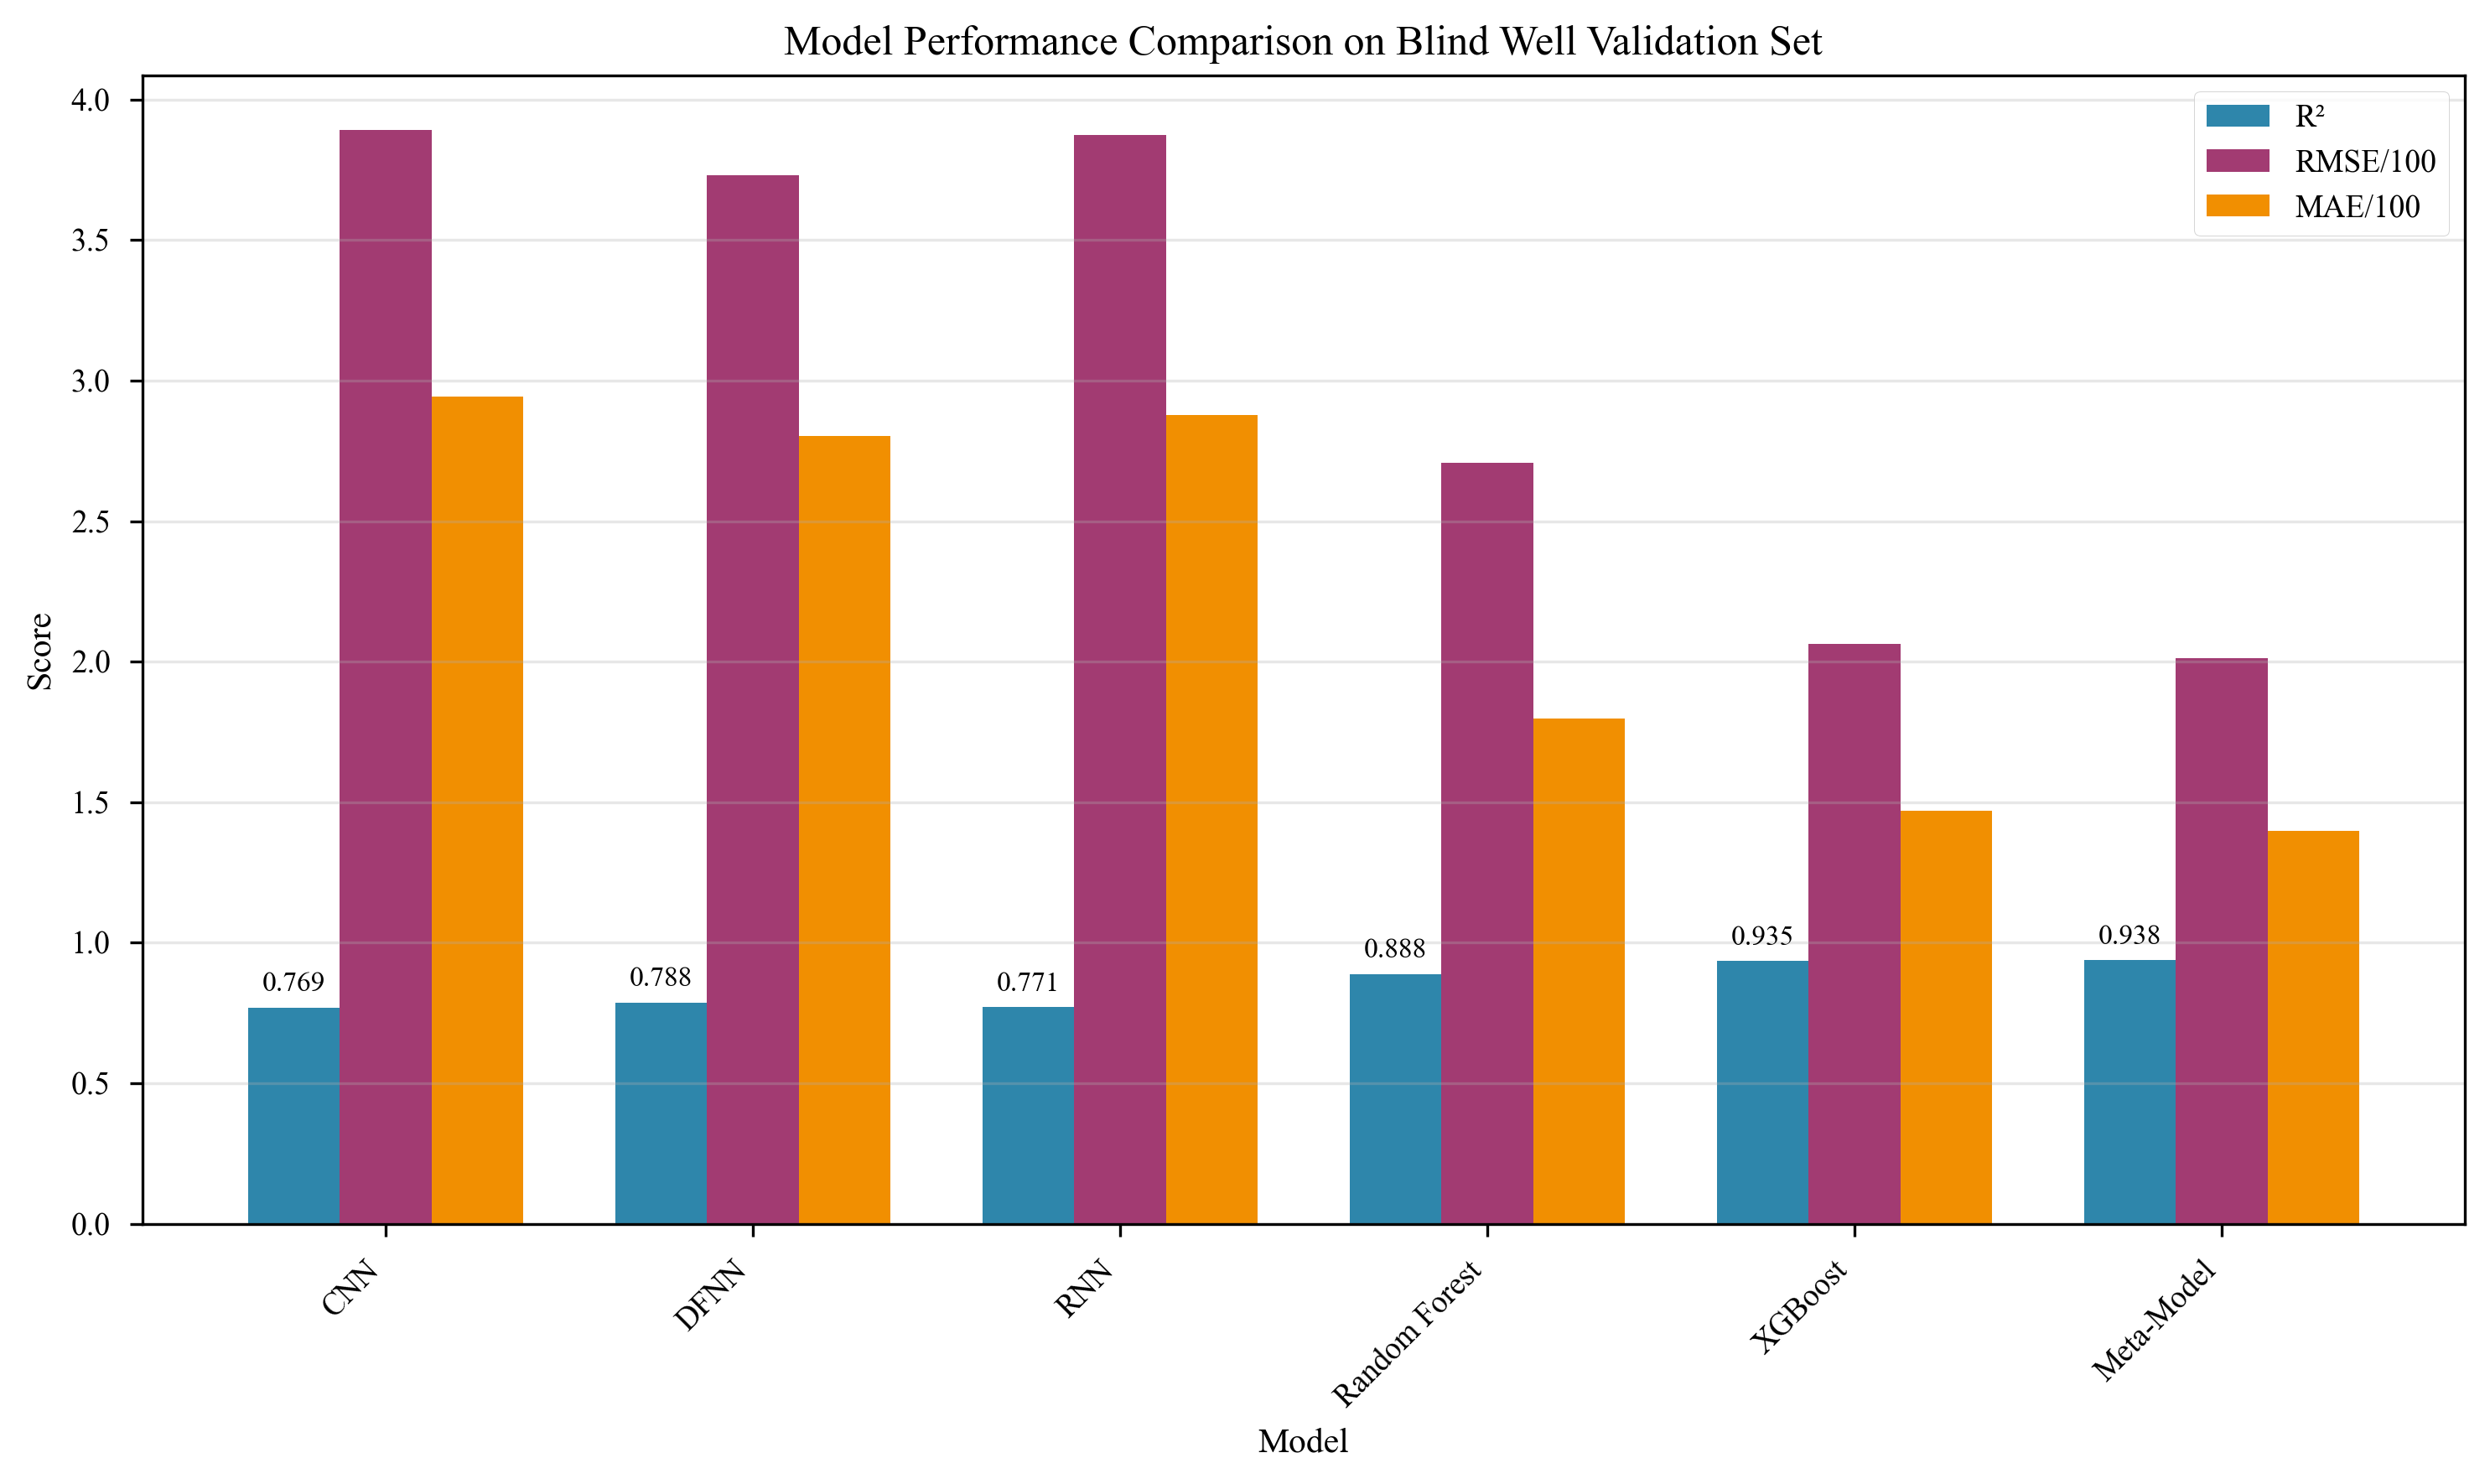

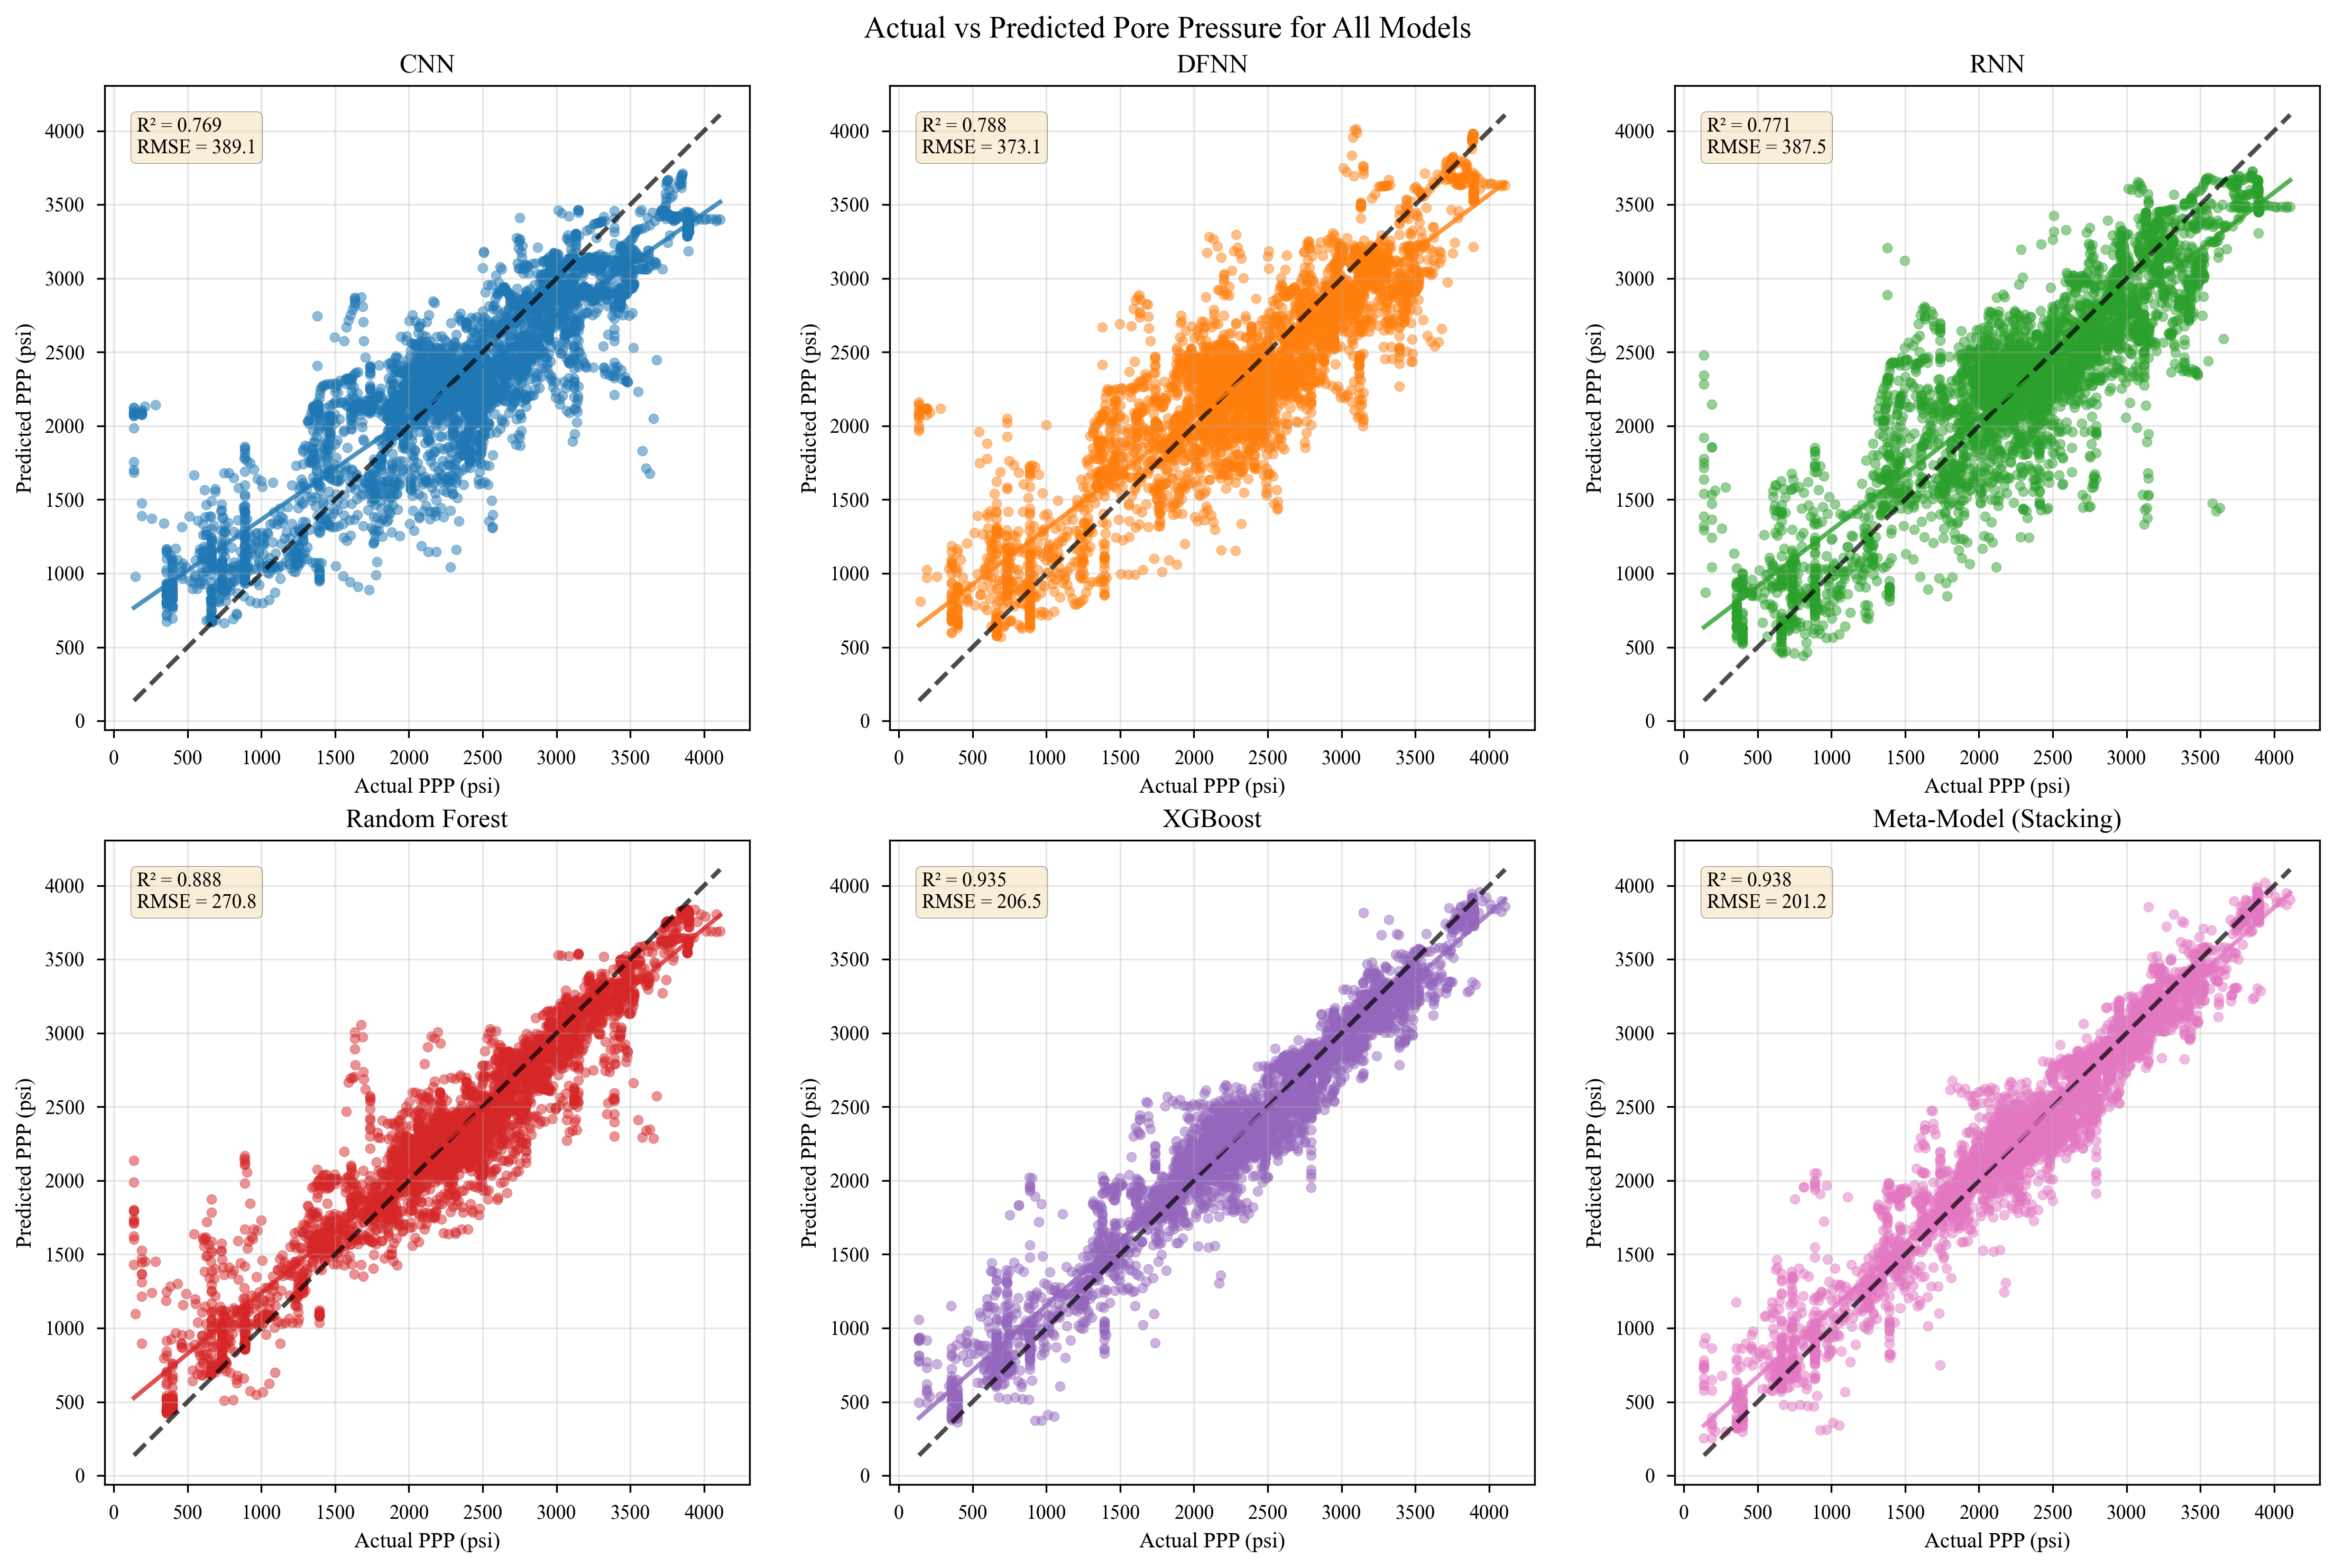

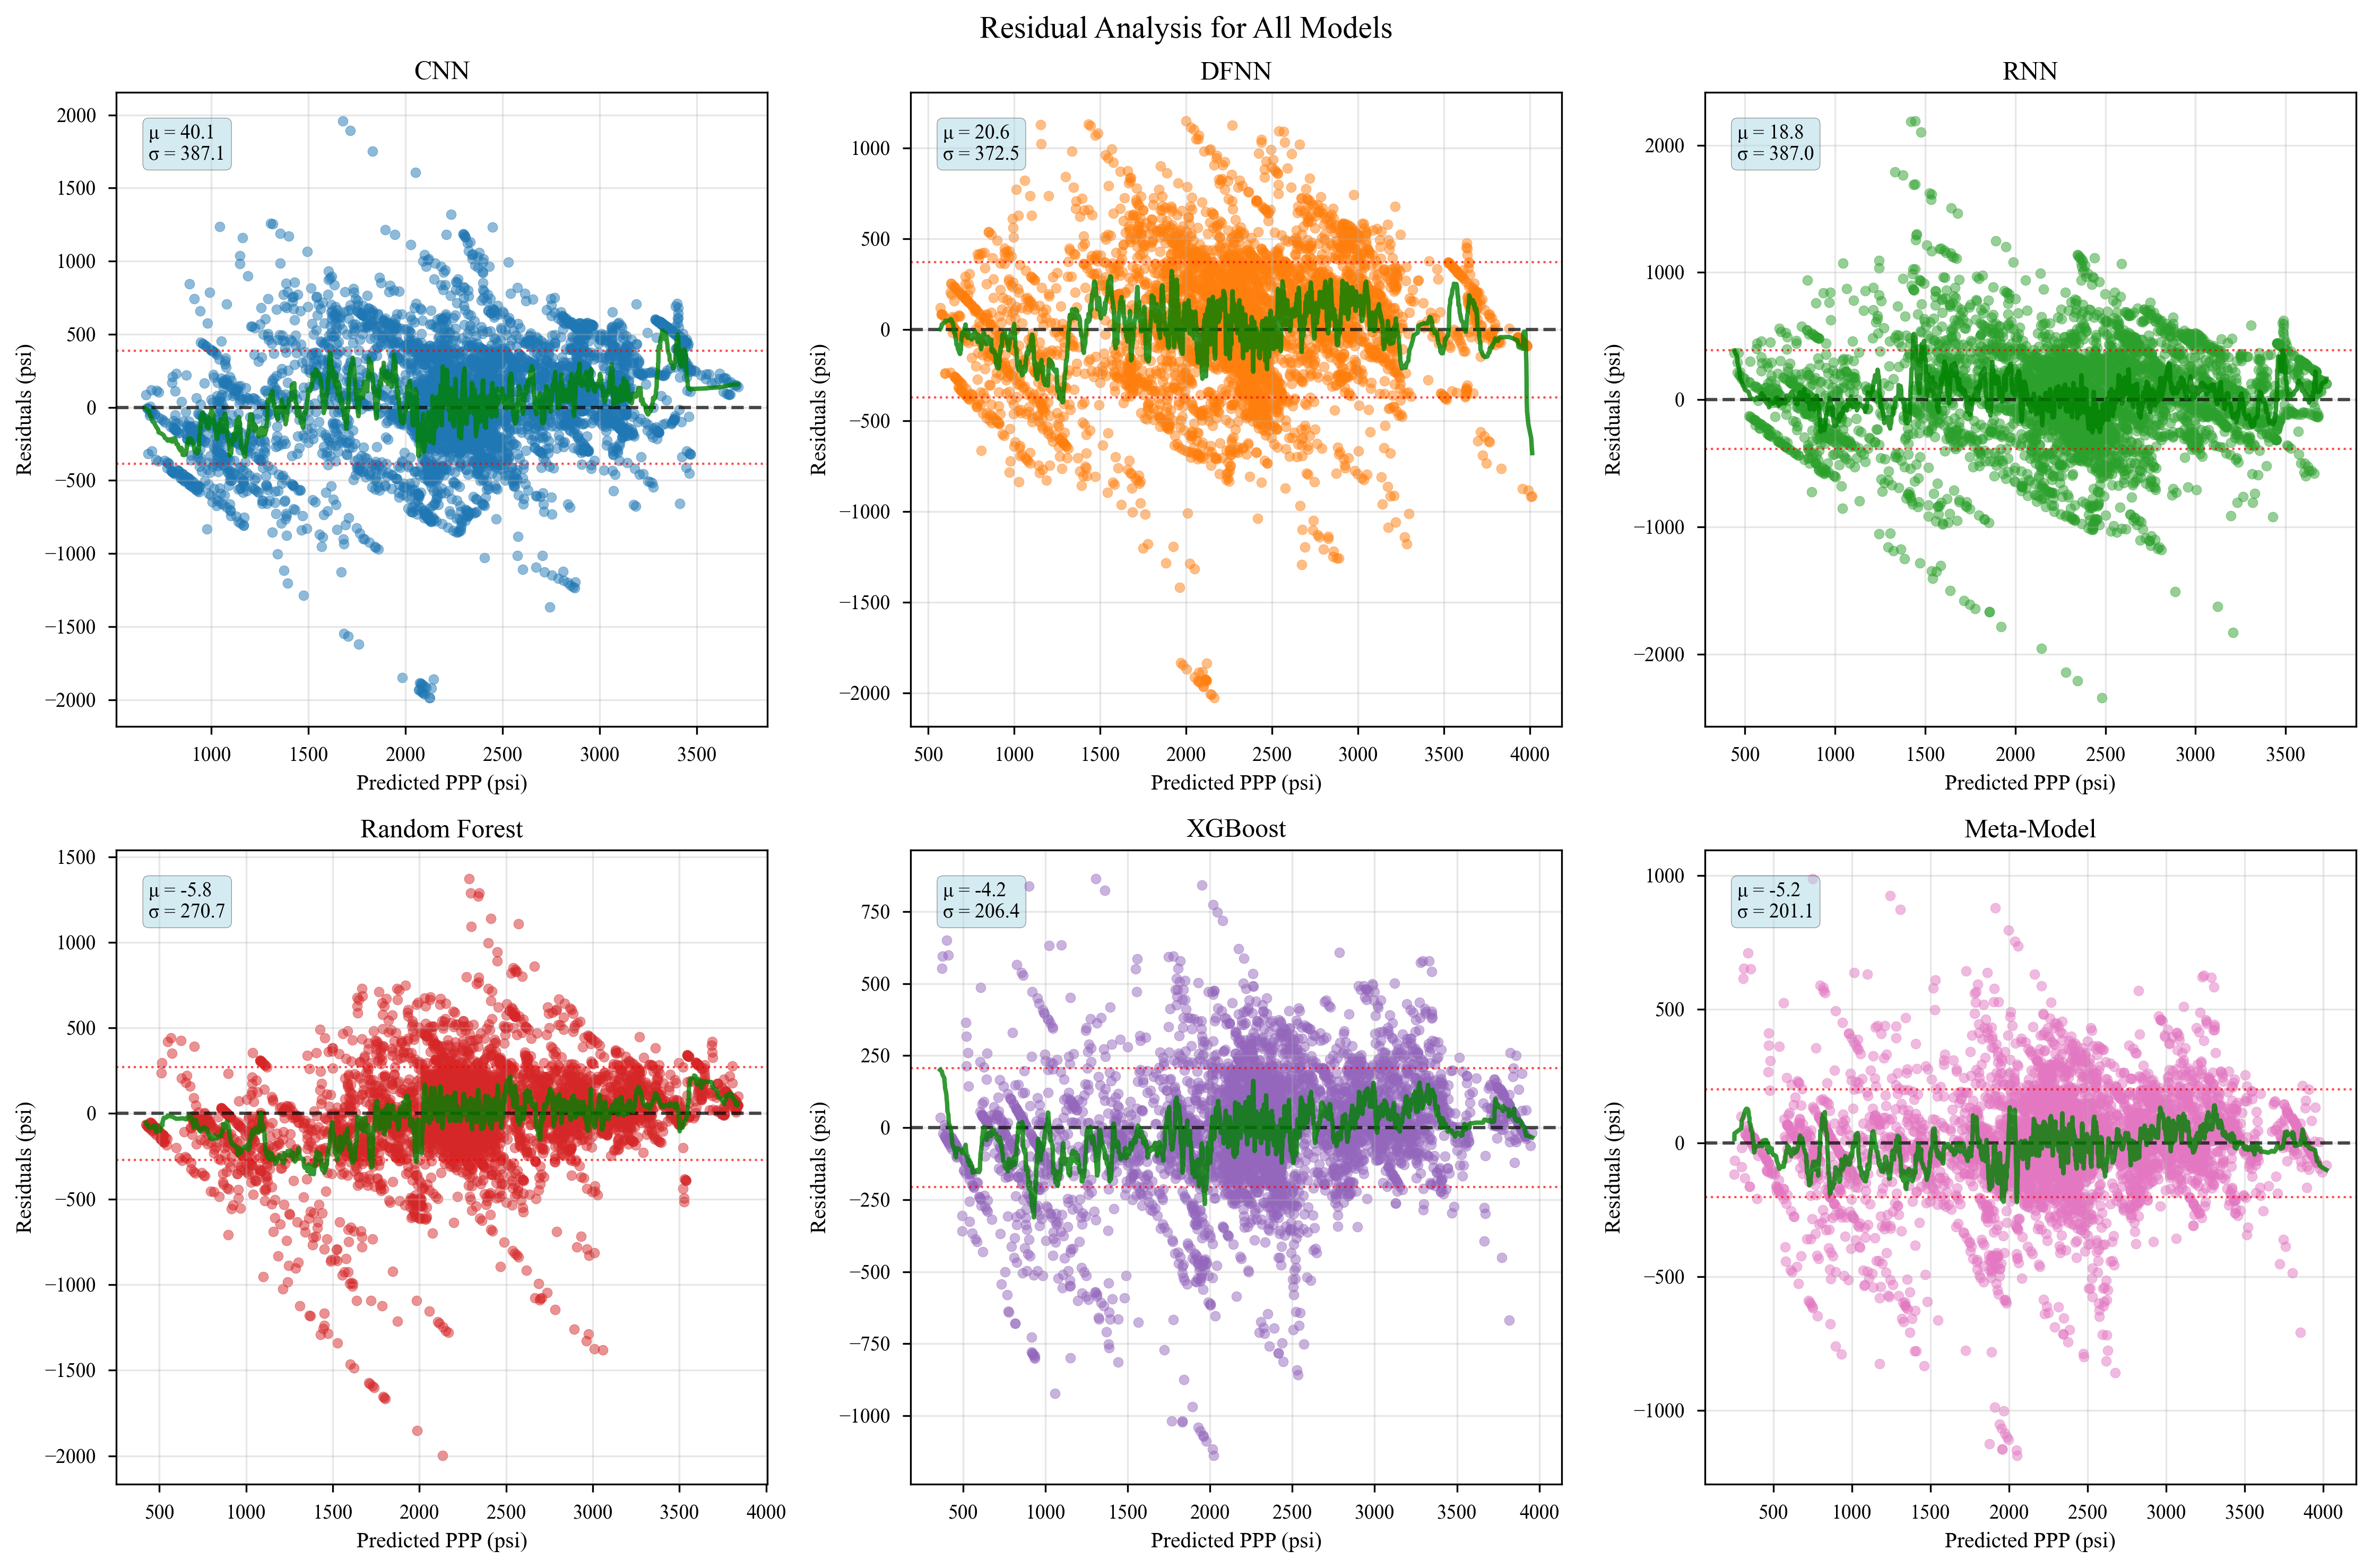

C:\Users\rohan\AppData\Local\Temp\ipykernel_22952\2001033640.py:307: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(all_predictions, labels=all_names, patch_artist=True, notch=True)


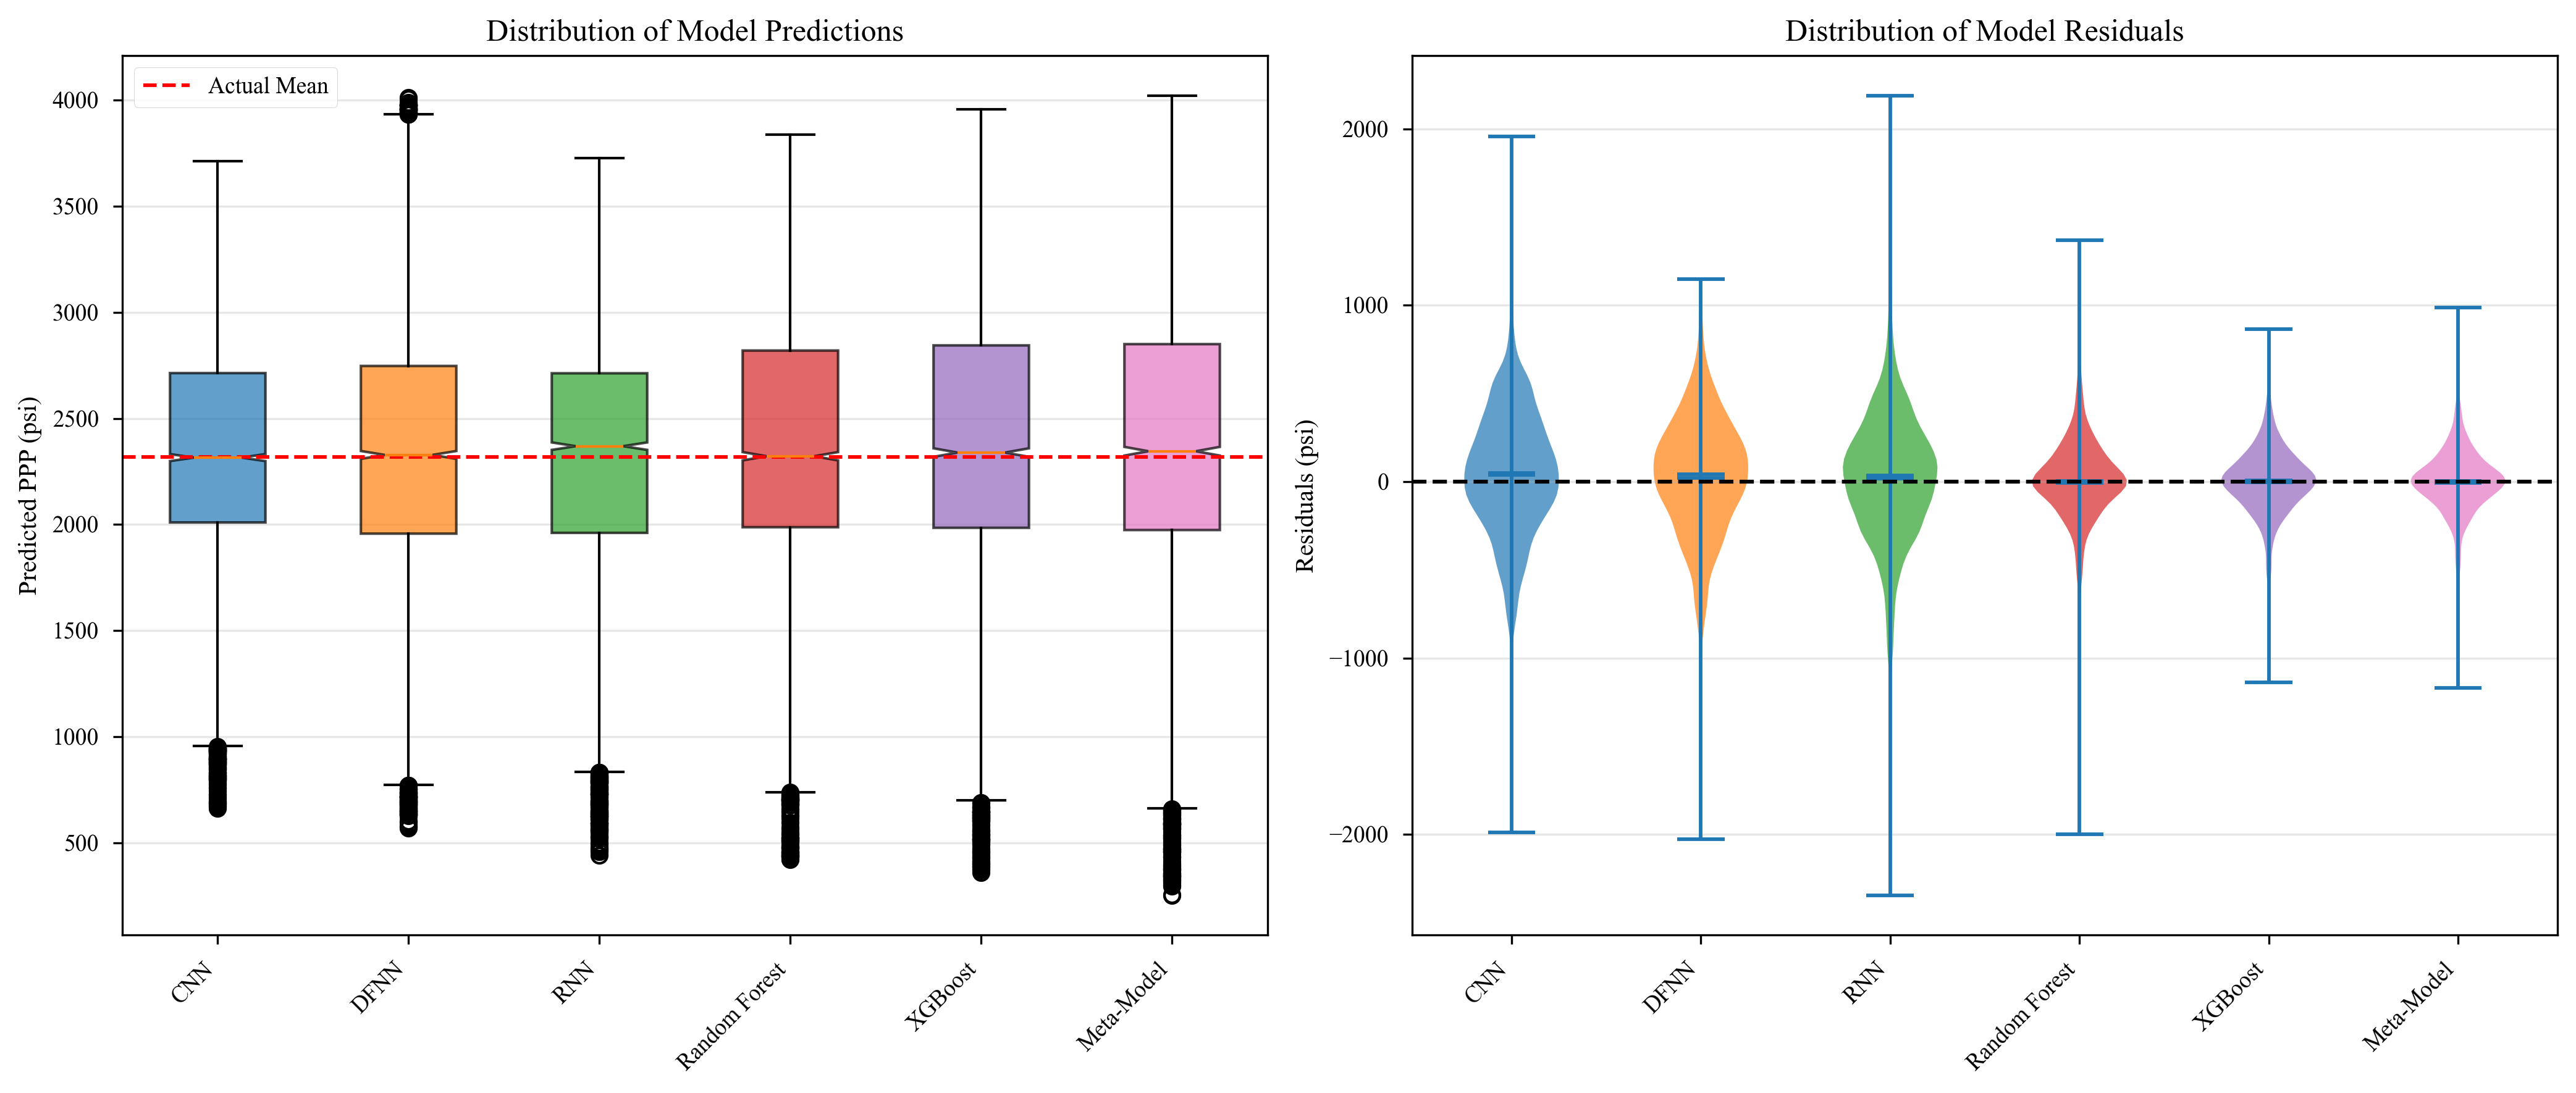

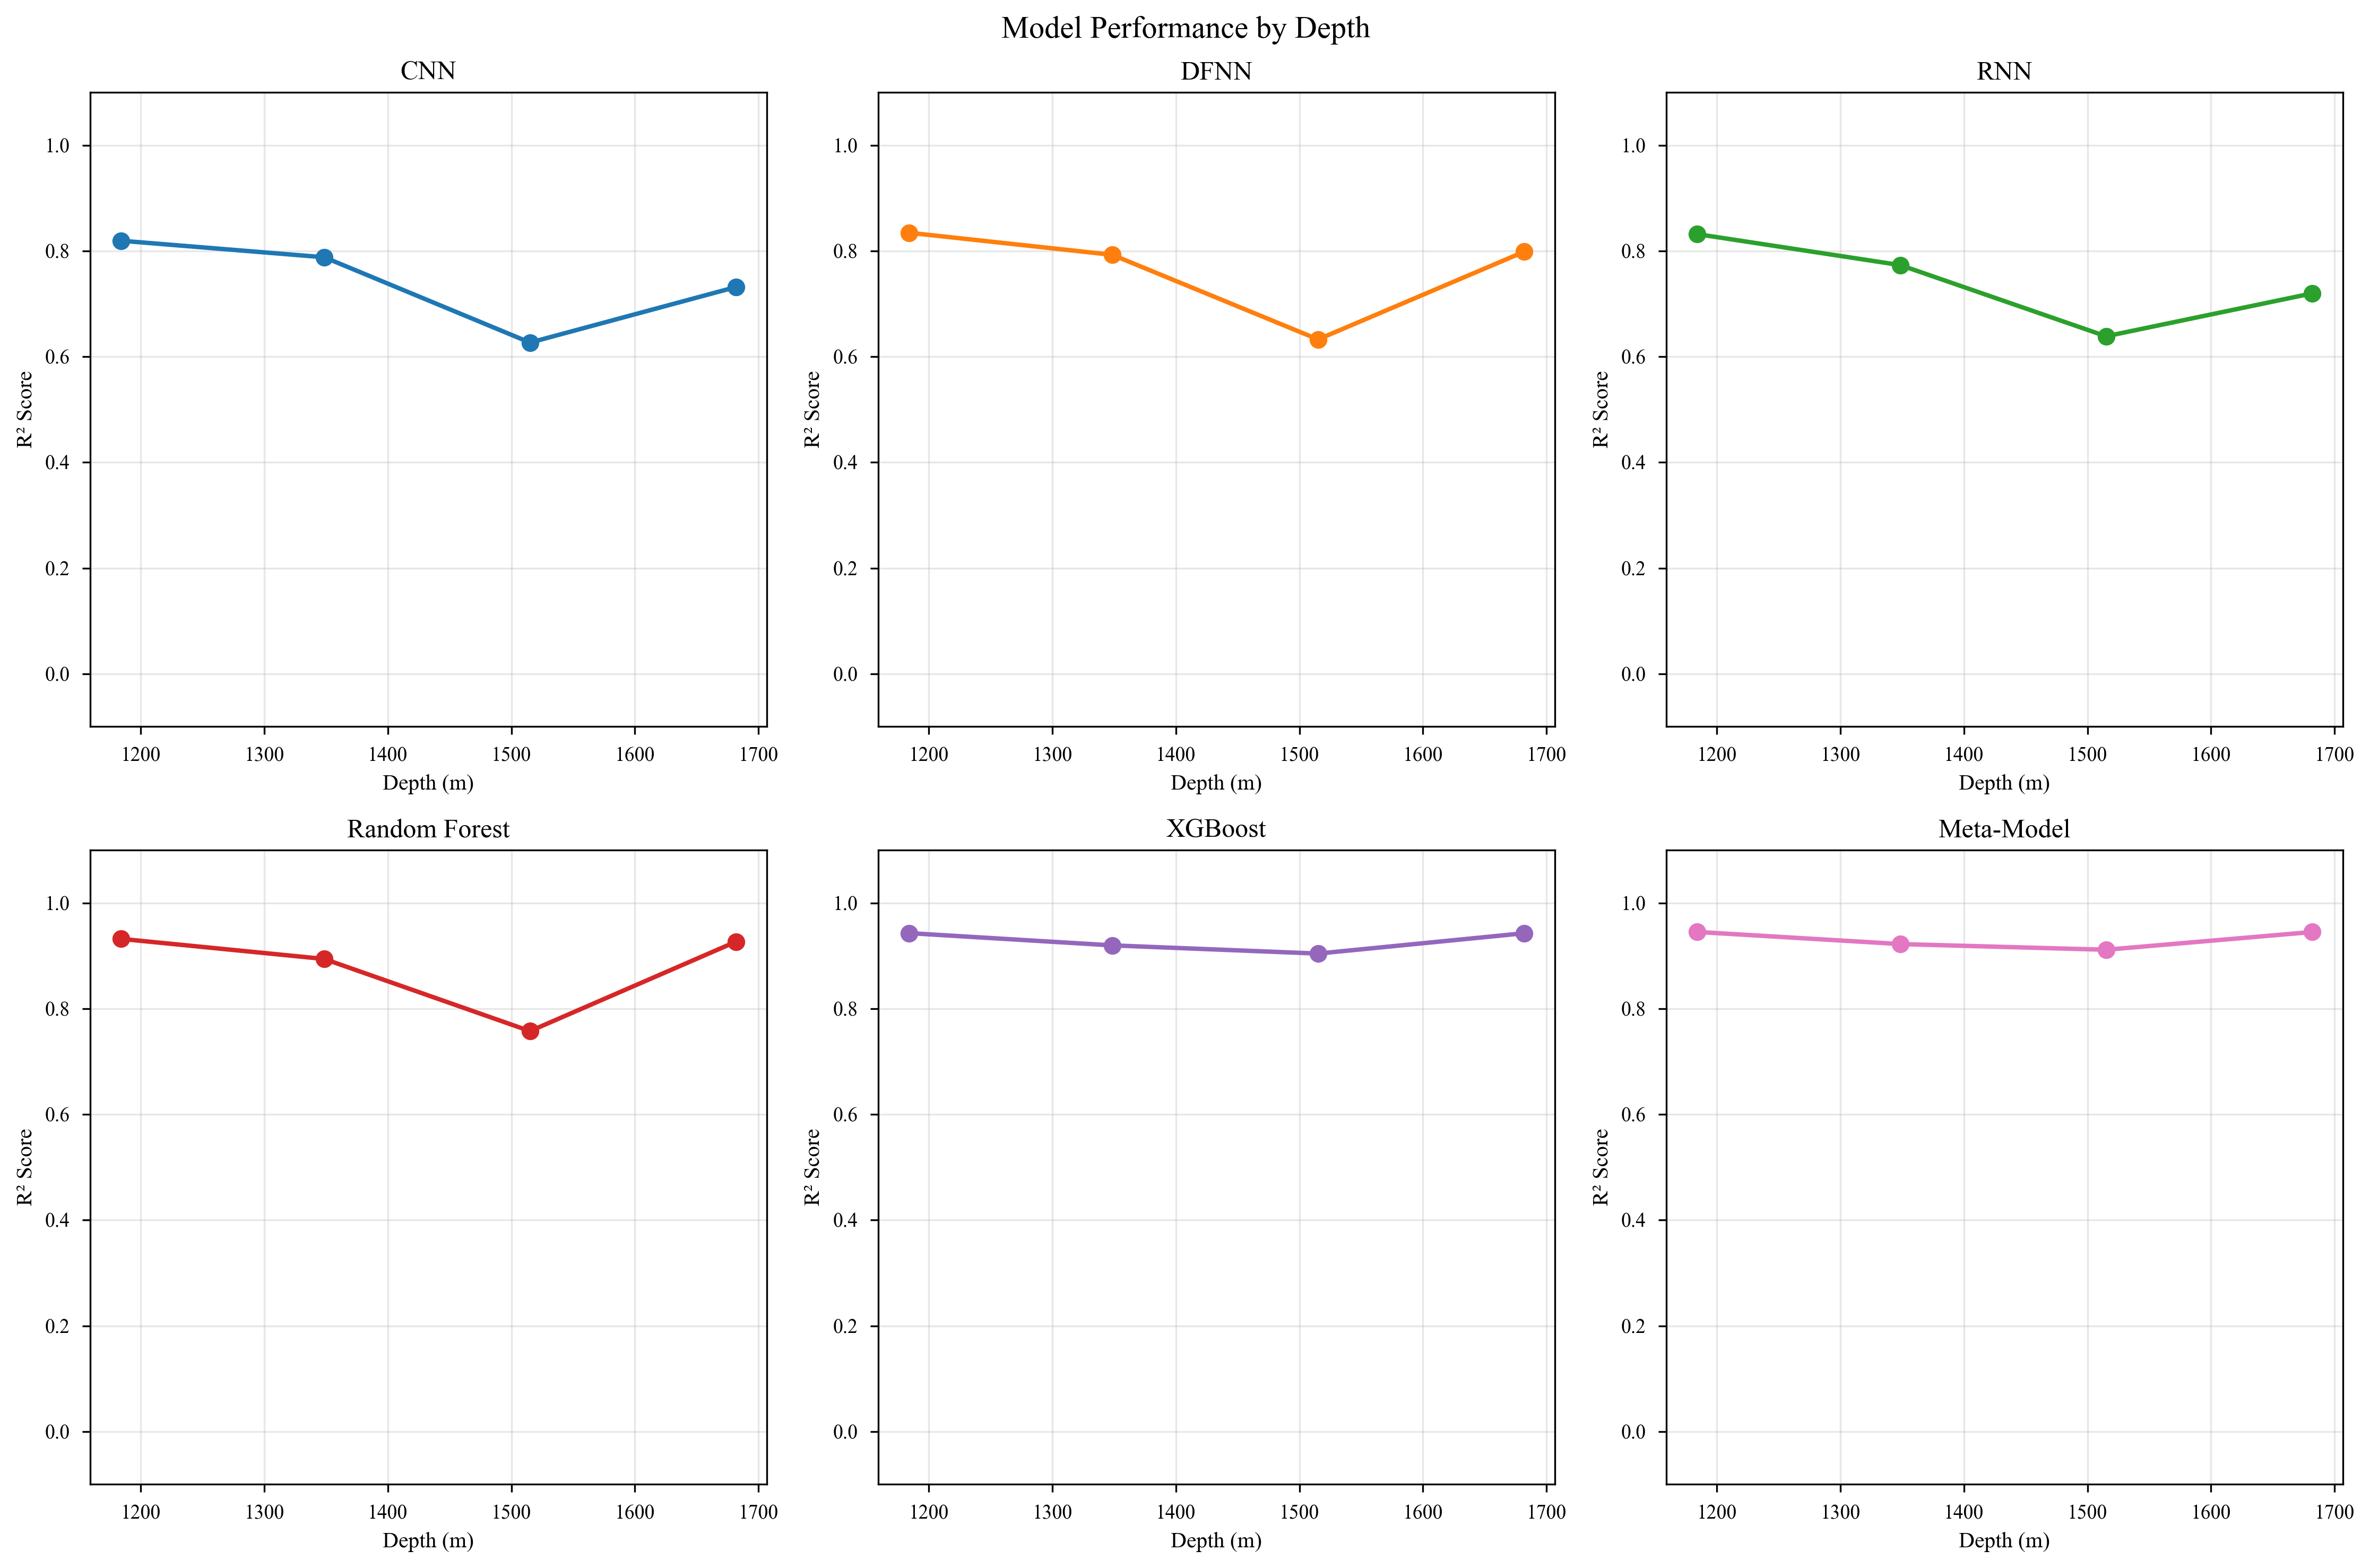

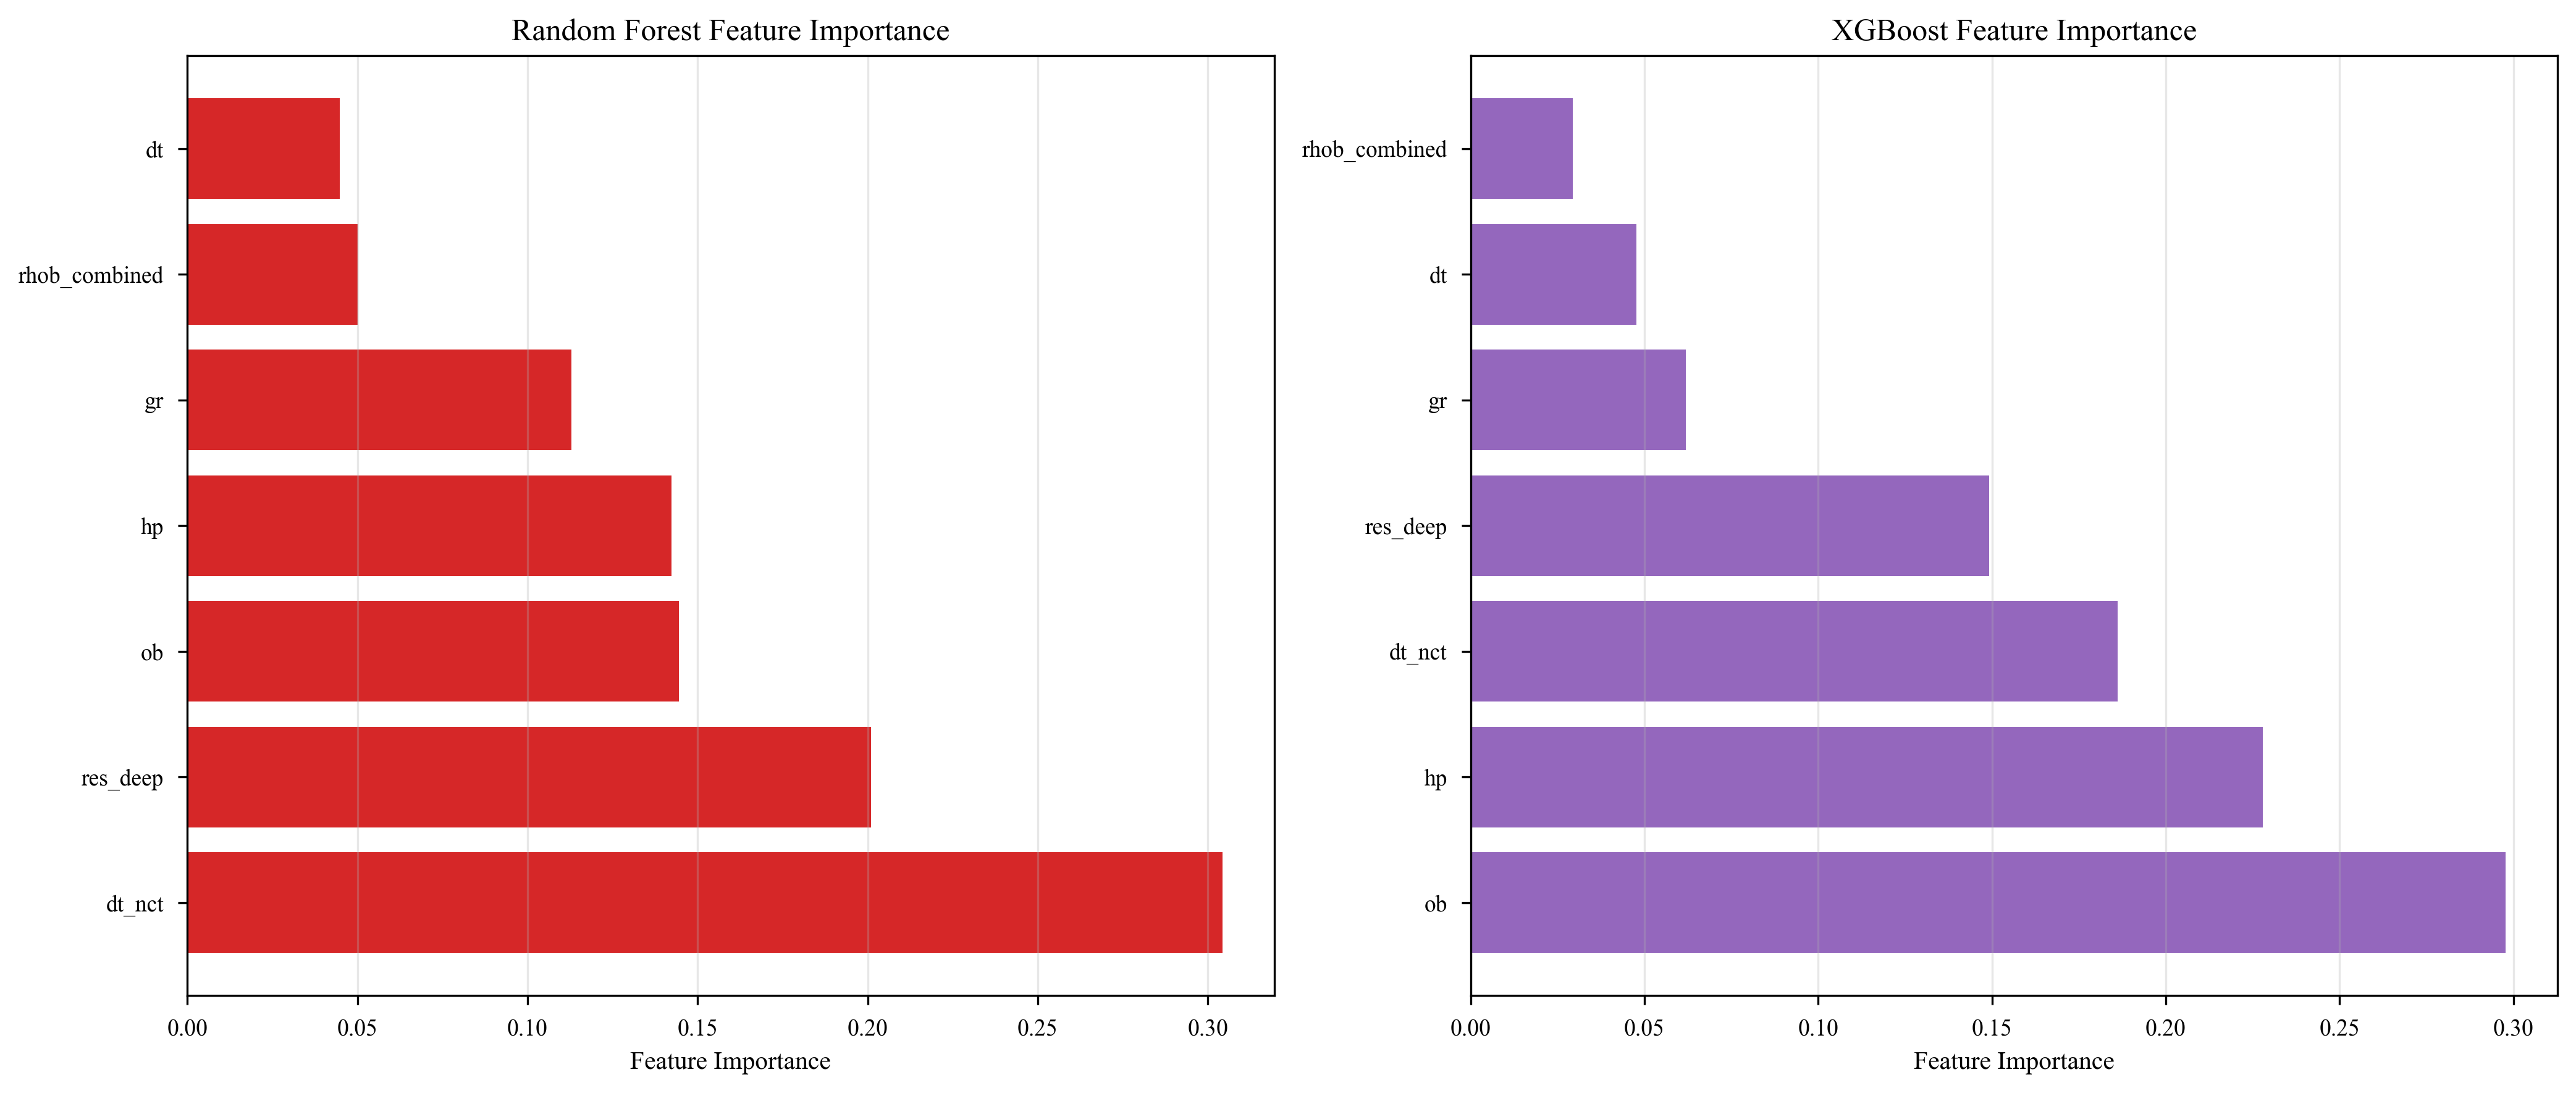

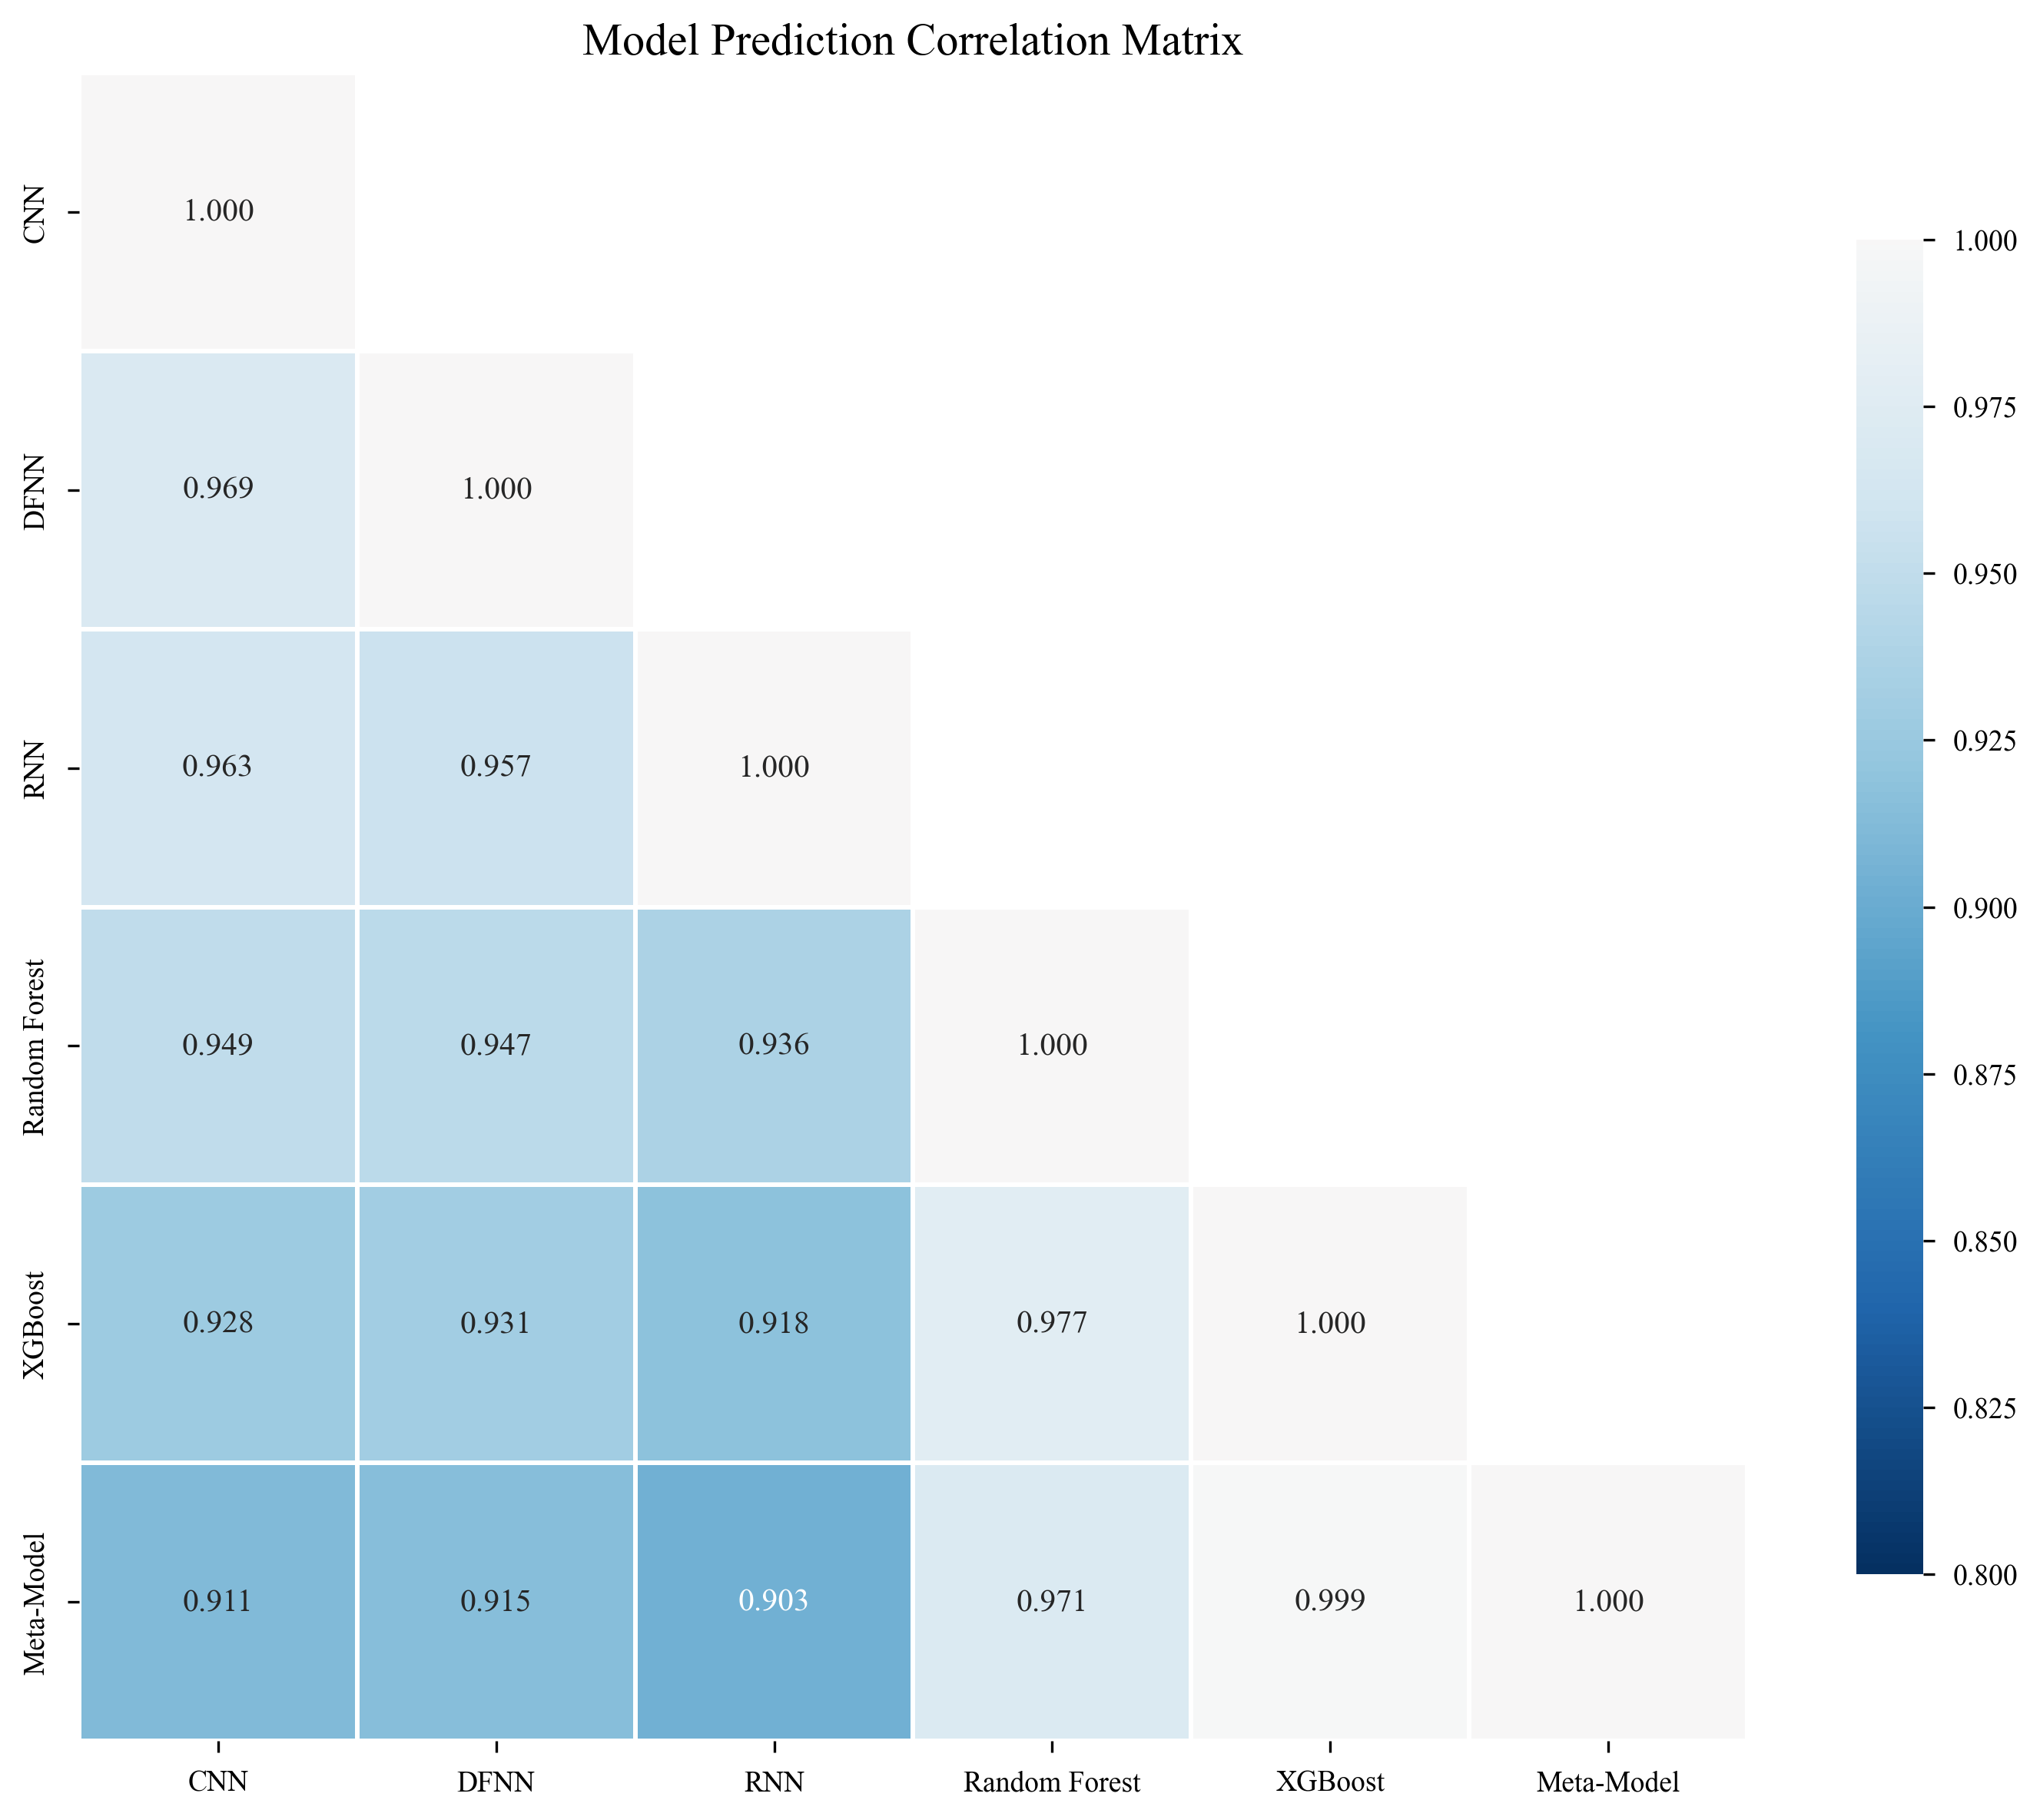


SUMMARY STATISTICS
        Model     R²   RMSE    MAE MAPE (%)
          CNN 0.7692 389.13 294.34    22.41
         DFNN 0.7878 373.11 280.37    21.58
          RNN 0.7712 387.45 287.75    20.55
Random Forest 0.8883 270.77 179.66    15.05
      XGBoost 0.9350 206.46 147.12    10.68
   Meta-Model 0.9383 201.15 139.87     9.67

Best performing model: Meta-Model

✅ All visualizations saved successfully!


In [10]:
## Meta-Model Ensemble and Visualizations

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

# Set plot style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.figsize': (8, 6),
    'font.family': 'serif',
    'font.serif': ['Times New Roman']
})

# Define consistent color palette
colors = {
    'CNN': '#1f77b4',
    'DFNN': '#ff7f0e',
    'RNN': '#2ca02c',
    'Random Forest': '#d62728',
    'XGBoost': '#9467bd',
    'Meta-Model': '#e377c2'
}

# ============================================
# META-MODEL IMPLEMENTATION
# ============================================

class MetaModel:
    def __init__(self, models, model_names):
        self.models = models
        self.model_names = model_names
        self.weights = None
        self.stacking_model = None

    def get_predictions(self, X_dict):
        """Get predictions from all base models"""
        predictions = {}
        predictions['CNN'] = self.models['CNN'].predict(X_dict['CNN']).flatten()
        predictions['DFNN'] = self.models['DFNN'].predict(X_dict['DFNN']).flatten()
        predictions['RNN'] = self.models['RNN'].predict(X_dict['RNN']).flatten()
        predictions['Random Forest'] = self.models['Random Forest'].predict(X_dict['RF']).flatten()
        predictions['XGBoost'] = self.models['XGBoost'].predict(X_dict['XGB']).flatten()
        return predictions

    def simple_average(self, predictions):
        pred_array = np.column_stack([predictions[name] for name in self.model_names])
        return np.mean(pred_array, axis=1)

    def weighted_average(self, predictions, weights=None):
        if weights is None:
            weights = self.weights
        pred_array = np.column_stack([predictions[name] for name in self.model_names])
        return np.average(pred_array, axis=1, weights=weights)

    def fit_stacking(self, X_dict, y_true, cv_folds=5):
        predictions = self.get_predictions(X_dict)
        pred_array = np.column_stack([predictions[name] for name in self.model_names])

        self.stacking_model = Ridge(alpha=1.0)
        self.stacking_model.fit(pred_array, y_true)

        scores = []
        for name in self.model_names:
            score = r2_score(y_true, predictions[name])
            scores.append(max(0, score))  # Ensure non-negative

        total_score = sum(scores)
        if total_score == 0:
            self.weights = [1/len(scores)] * len(scores)  # Even weights if all scores are zero
        else:
            self.weights = [s / total_score for s in scores]

        print("Model Weights (based on R² scores):")
        for name, weight in zip(self.model_names, self.weights):
            print(f"  {name}: {weight:.3f}")

        return self

    def predict(self, X_dict, method='stacking'):
        predictions = self.get_predictions(X_dict)

        if method == 'simple':
            return self.simple_average(predictions)
        elif method == 'weighted':
            return self.weighted_average(predictions)
        elif method == 'stacking':
            pred_array = np.column_stack([predictions[name] for name in self.model_names])
            return self.stacking_model.predict(pred_array)
        else:
            raise ValueError(f"Unknown method: {method}")


print("Creating Meta-Model Ensemble...")

models = {
    'CNN': cnn_f,
    'DFNN': dfnn_f,
    'RNN': rnn_f,
    'Random Forest': rf_f,
    'XGBoost': xgb_f
}

model_names = ['CNN', 'DFNN', 'RNN', 'Random Forest', 'XGBoost']

X_ft_dict = {
    'CNN': X_ft_cnn,
    'DFNN': X_ft,
    'RNN': X_ft_rnn,
    'RF': X_ft,
    'XGB': X_ft
}

X_val_dict = {
    'CNN': X_val_cnn,
    'DFNN': X_val,
    'RNN': X_val_rnn,
    'RF': X_val,
    'XGB': X_val
}

meta_model = MetaModel(models, model_names)
meta_model.fit_stacking(X_ft_dict, y_ft)

y_pred_simple = meta_model.predict(X_val_dict, method='simple')
y_pred_weighted = meta_model.predict(X_val_dict, method='weighted')
y_pred_stacking = meta_model.predict(X_val_dict, method='stacking')

print("\n🔮 Meta-Model Results on Blind Well:")
eval_model("Simple Average", y_val, y_pred_simple)
eval_model("Weighted Average", y_val, y_pred_weighted)
eval_model("Stacking", y_val, y_pred_stacking)

# ============================================
# PART 2: VISUALIZATIONS
# ============================================

individual_predictions = meta_model.get_predictions(X_val_dict)

# Figure 1: Model Performance Comparison
fig, ax = plt.subplots(figsize=(10, 6))

model_names_all = model_names + ['Meta-Model']

r2_scores = [r2_score(y_val, individual_predictions[name]) for name in model_names]
r2_scores.append(r2_score(y_val, y_pred_stacking))

rmse_scores = [np.sqrt(mean_squared_error(y_val, individual_predictions[name])) for name in model_names]
rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred_stacking)))

mae_scores = [mean_absolute_error(y_val, individual_predictions[name]) for name in model_names]
mae_scores.append(mean_absolute_error(y_val, y_pred_stacking))  # Fixed extra parenthesis here

x = np.arange(len(model_names_all))
width = 0.25

bars1 = ax.bar(x - width, r2_scores, width, label='R²', color='#2E86AB')
bars2 = ax.bar(x, np.array(rmse_scores)/100, width, label='RMSE/100', color='#A23B72')
bars3 = ax.bar(x + width, np.array(mae_scores)/100, width, label='MAE/100', color='#F18F01')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison on Blind Well Validation Set')
ax.set_xticks(x)
ax.set_xticklabels(model_names_all, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1]:
    for bar, score in zip(bars, r2_scores):
        height = bar.get_height()
        ax.annotate(f'{score:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Figure 2: Prediction Scatter Plots (2x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, pred) in enumerate(individual_predictions.items()):
    ax = axes[idx]

    r2 = r2_score(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))

    ax.scatter(y_val, pred, alpha=0.5, s=20, color=colors[name], edgecolors=None)

    min_val, max_val = y_val.min(), y_val.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.7)

    z = np.polyfit(y_val, pred, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min_val, max_val, 100)
    ax.plot(x_line, p(x_line), "-", color=colors[name], lw=2, alpha=0.8)

    ax.set_xlabel('Actual PPP (psi)')
    ax.set_ylabel('Predicted PPP (psi)')
    ax.set_title(f'{name}')

    textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.1f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)

# Meta-model in the last subplot
ax = axes[5]
ax.scatter(y_val, y_pred_stacking, alpha=0.5, s=20, color=colors['Meta-Model'], edgecolors=None)
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.7)
z = np.polyfit(y_val, y_pred_stacking, 1)
p = np.poly1d(z)
ax.plot(x_line, p(x_line), "-", color=colors['Meta-Model'], lw=2, alpha=0.8)
ax.set_xlabel('Actual PPP (psi)')
ax.set_ylabel('Predicted PPP (psi)')
ax.set_title('Meta-Model (Stacking)')
r2 = r2_score(y_val, y_pred_stacking)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_stacking))
textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.1f}'
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

plt.suptitle('Actual vs Predicted Pore Pressure for All Models', fontsize=14)
plt.tight_layout()
plt.savefig('prediction_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()


# Figure 3: Residual Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Helper to get window length for savgol_filter
def get_savgol_window_length(arr_length):
    winlen = min(51, (arr_length // 4) * 2 + 1)
    if winlen < 3:
        winlen = 3  # Smallest allowed odd window length
    if winlen % 2 == 0:
        winlen += 1
    if winlen > arr_length:
        winlen = arr_length if arr_length %2 == 1 else arr_length - 1
    return winlen

for idx, (name, pred) in enumerate(list(individual_predictions.items()) + [('Meta-Model', y_pred_stacking)]):
    ax = axes[idx]

    residuals = y_val - pred

    ax.scatter(pred, residuals, alpha=0.5, s=20,
               color=colors.get(name, '#e377c2'), edgecolors=None)
    ax.axhline(y=0, color='k', linestyle='--', lw=1.5, alpha=0.7)

    std_res = np.std(residuals)
    ax.axhline(y=std_res, color='r', linestyle=':', lw=1, alpha=0.7)
    ax.axhline(y=-std_res, color='r', linestyle=':', lw=1, alpha=0.7)

    sorted_idx = np.argsort(pred)
    winlen = get_savgol_window_length(len(pred))
    # Apply smoothing only if enough points
    if len(pred) >= winlen:
        smooth_curve = savgol_filter(residuals[sorted_idx], window_length=winlen, polyorder=3)
        ax.plot(pred[sorted_idx], smooth_curve, 'g-', lw=2, alpha=0.8)

    ax.set_xlabel('Predicted PPP (psi)')
    ax.set_ylabel('Residuals (psi)')
    ax.set_title(f'{name}')
    ax.grid(True, alpha=0.3)

    textstr = f'μ = {np.mean(residuals):.1f}\nσ = {std_res:.1f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.suptitle('Residual Analysis for All Models', fontsize=14)
plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


# Figure 4: Model Prediction Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

all_predictions = [individual_predictions[name] for name in model_names] + [y_pred_stacking]
all_names = model_names + ['Meta-Model']

bp = ax1.boxplot(all_predictions, labels=all_names, patch_artist=True, notch=True)
for patch, name in zip(bp['boxes'], all_names):
    patch.set_facecolor(colors.get(name, '#e377c2'))
    patch.set_alpha(0.7)

ax1.axhline(y=y_val.mean(), color='red', linestyle='--', label='Actual Mean')
ax1.set_ylabel('Predicted PPP (psi)')
ax1.set_title('Distribution of Model Predictions')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticklabels(all_names, rotation=45, ha='right')

residuals_all = [y_val - individual_predictions[name] for name in model_names] + [y_val - y_pred_stacking]

parts = ax2.violinplot(residuals_all, positions=range(len(all_names)), showmeans=True, showmedians=True)
for pc, name in zip(parts['bodies'], all_names):
    pc.set_facecolor(colors.get(name, '#e377c2'))
    pc.set_alpha(0.7)

ax2.axhline(y=0, color='k', linestyle='--', lw=1.5)
ax2.set_xticks(range(len(all_names)))
ax2.set_xticklabels(all_names, rotation=45, ha='right')
ax2.set_ylabel('Residuals (psi)')
ax2.set_title('Distribution of Model Residuals')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('prediction_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


# Figure 5: Depth-wise Performance
if 'depth' in df_val.columns:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    depths = df_val['depth'].values

    for idx, (name, pred) in enumerate(list(individual_predictions.items())[:5]):
        ax = axes[idx]

        depth_bins = np.percentile(depths, [0, 25, 50, 75, 100])
        bin_centers = [(depth_bins[i] + depth_bins[i + 1]) / 2 for i in range(len(depth_bins) - 1)]

        r2_by_depth = []
        for i in range(len(depth_bins) - 1):
            mask = (depths >= depth_bins[i]) & (depths < depth_bins[i + 1])
            if mask.sum() > 10:
                r2 = r2_score(y_val[mask], pred[mask])
                r2_by_depth.append(r2)
            else:
                r2_by_depth.append(np.nan)

        ax.plot(bin_centers, r2_by_depth, 'o-', color=colors[name], lw=2, markersize=8)
        ax.set_xlabel('Depth (m)')
        ax.set_ylabel('R² Score')
        ax.set_title(f'{name}')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([-0.1, 1.1])

    ax = axes[5]
    r2_by_depth = []
    for i in range(len(depth_bins) - 1):
        mask = (depths >= depth_bins[i]) & (depths < depth_bins[i + 1])
        if mask.sum() > 10:
            r2 = r2_score(y_val[mask], y_pred_stacking[mask])
            r2_by_depth.append(r2)
        else:
            r2_by_depth.append(np.nan)

    ax.plot(bin_centers, r2_by_depth, 'o-', color=colors['Meta-Model'], lw=2, markersize=8)
    ax.set_xlabel('Depth (m)')
    ax.set_ylabel('R² Score')
    ax.set_title('Meta-Model')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-0.1, 1.1])

    plt.suptitle('Model Performance by Depth', fontsize=14)
    plt.tight_layout()
    plt.savefig('depth_wise_performance.png', dpi=300, bbox_inches='tight')
    plt.show()


# Figure 6: Feature Importance (for tree-based models)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest feature importance
rf_importance = rf_f.feature_importances_
indices_rf = np.argsort(rf_importance)[::-1]
ax1.barh(range(len(features)), rf_importance[indices_rf], color=colors['Random Forest'])
ax1.set_yticks(range(len(features)))
ax1.set_yticklabels([features[i] for i in indices_rf])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Random Forest Feature Importance')
ax1.grid(True, alpha=0.3, axis='x')

# XGBoost feature importance
xgb_importance = xgb_f.feature_importances_
indices_xgb = np.argsort(xgb_importance)[::-1]
ax2.barh(range(len(features)), xgb_importance[indices_xgb], color=colors['XGBoost'])
ax2.set_yticks(range(len(features)))
ax2.set_yticklabels([features[i] for i in indices_xgb])
ax2.set_xlabel('Feature Importance')
ax2.set_title('XGBoost Feature Importance')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


# Figure 7: Model Agreement Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

pred_df = pd.DataFrame({name: individual_predictions[name] for name in model_names})
pred_df['Meta-Model'] = y_pred_stacking
corr_matrix = pred_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f',
            cmap='RdBu_r', center=1.0, vmin=0.8, vmax=1.0,
            square=True, linewidths=1, cbar_kws={"shrink": .8})

plt.title('Model Prediction Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('model_agreement_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


# Summary Statistics Table
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

summary_data = []
for name in model_names + ['Meta-Model']:
    pred = y_pred_stacking if name == 'Meta-Model' else individual_predictions[name]

    r2 = r2_score(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    mae = mean_absolute_error(y_val, pred)
    mape = np.mean(np.abs((y_val - pred) / y_val)) * 100

    summary_data.append({
        'Model': name,
        'R²': f"{r2:.4f}",
        'RMSE': f"{rmse:.2f}",
        'MAE': f"{mae:.2f}",
        'MAPE (%)': f"{mape:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("\nBest performing model:", summary_df.loc[summary_df['R²'].astype(float).idxmax(), 'Model'])

# Save summary table
summary_df.to_csv('model_performance_summary.csv', index=False)
print("\n✅ All visualizations saved successfully!")


Sample count in depth bin around 1500 ft (1452.0 to 1502.0): 327


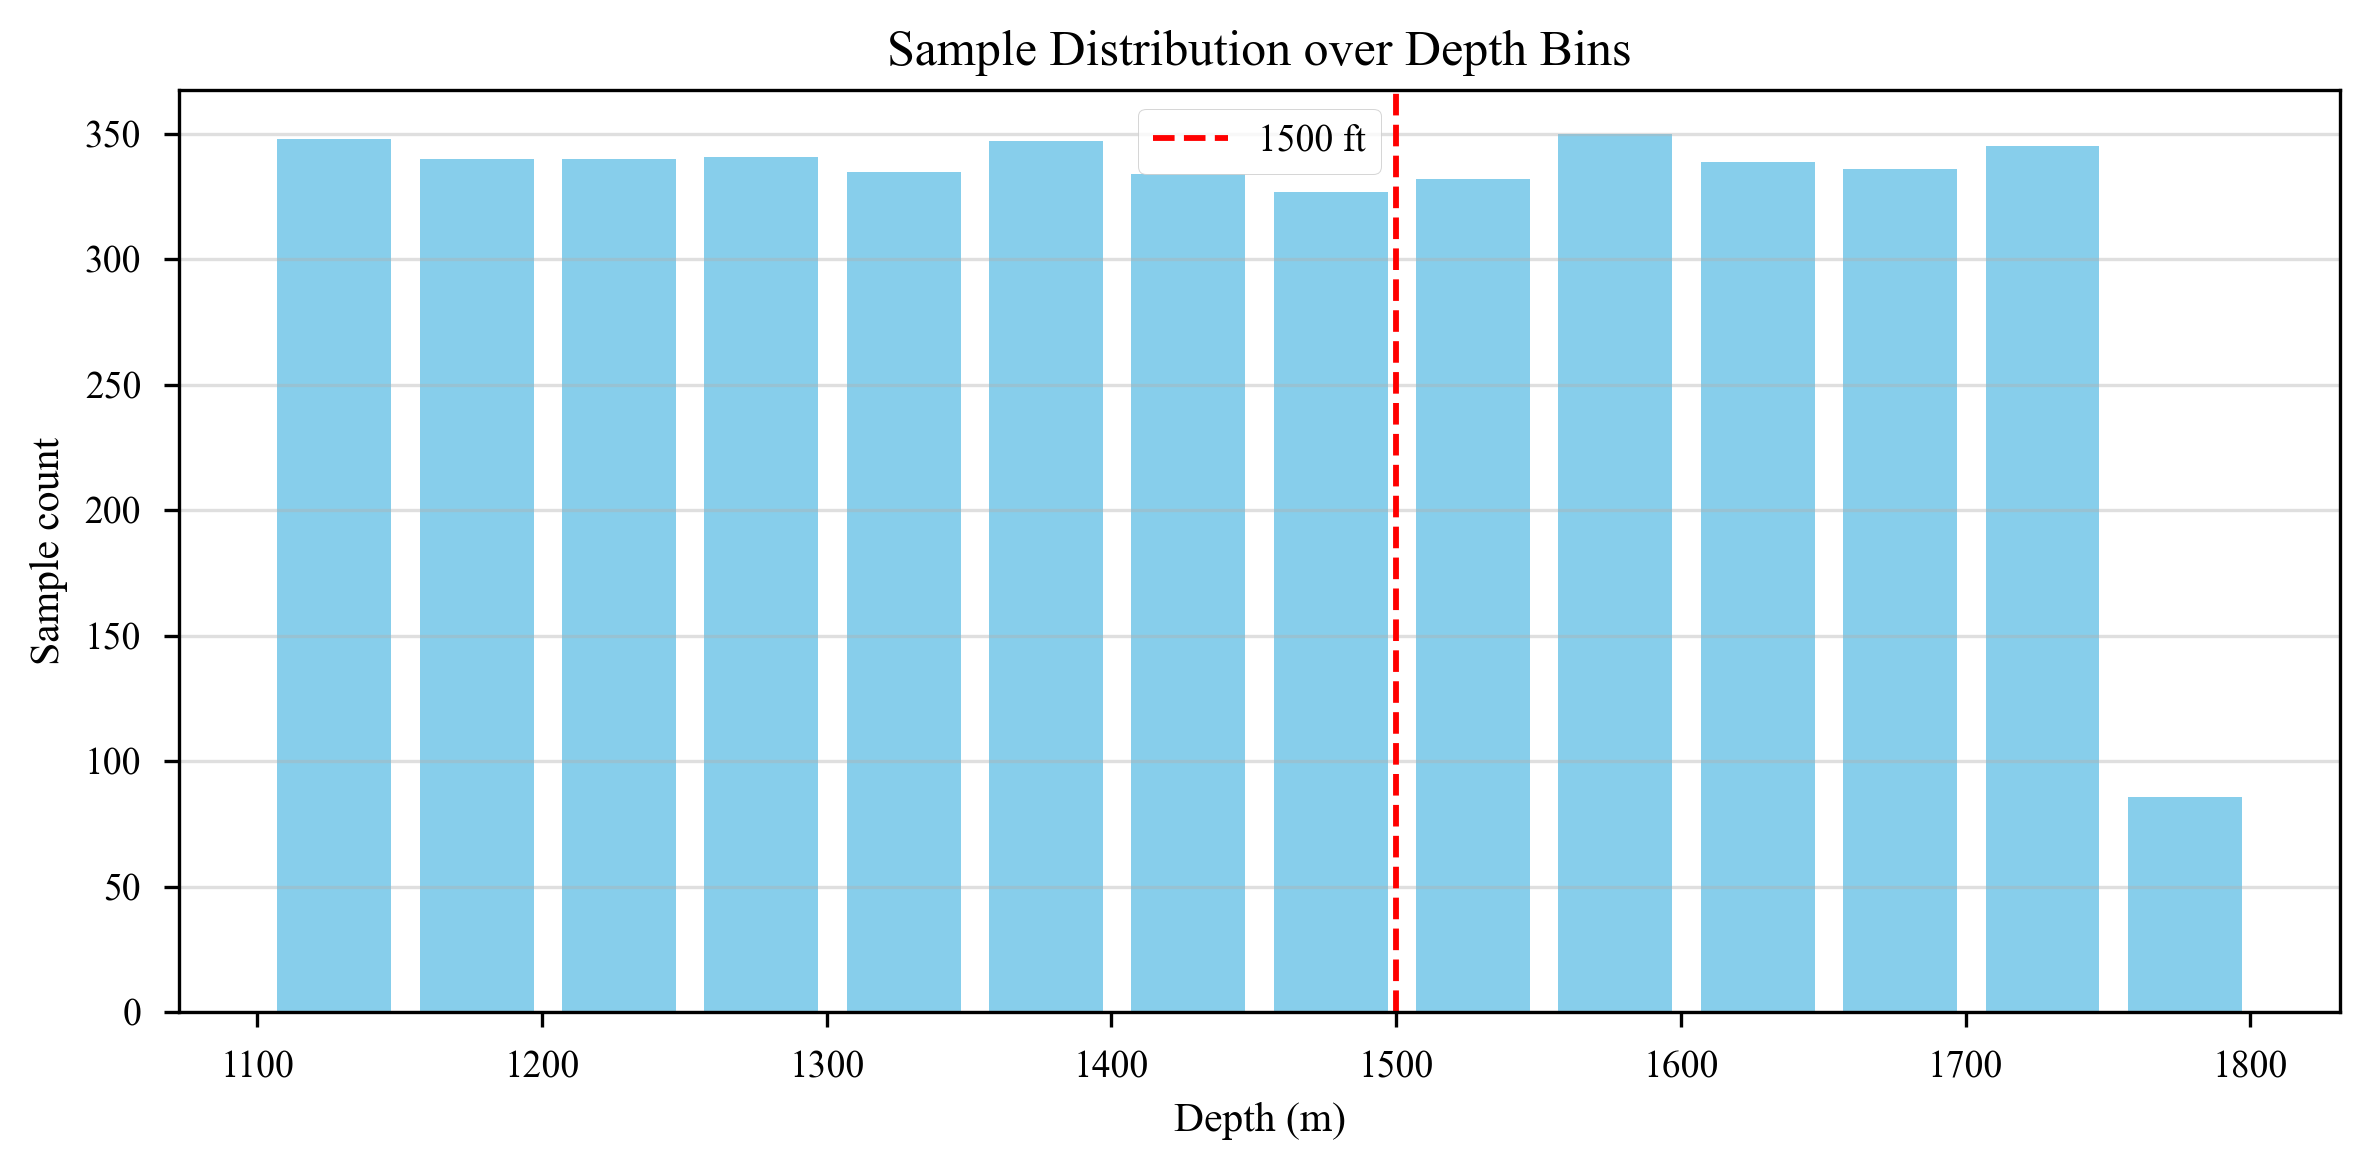

In [11]:
import numpy as np
import matplotlib.pyplot as plt


bin_width = 50  
bins = np.arange(df_val['depth'].min(), df_val['depth'].max() + bin_width, bin_width)
sample_counts, bin_edges = np.histogram(df_val['depth'], bins=bins)
bin_index = np.digitize(1500, bin_edges) - 1

print(f"Sample count in depth bin around 1500 ft ({bin_edges[bin_index]} to {bin_edges[bin_index+1]}): {sample_counts[bin_index]}")

plt.figure(figsize=(8, 4))
plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, sample_counts, width=bin_width * 0.8, color='skyblue')
plt.axvline(1500, color='red', linestyle='--', label='1500 ft')
plt.xlabel('Depth (m)')
plt.ylabel('Sample count')
plt.title('Sample Distribution over Depth Bins')
plt.legend()
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\rohan\AppData\Local\Temp\ipykernel_22952\3127745045.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


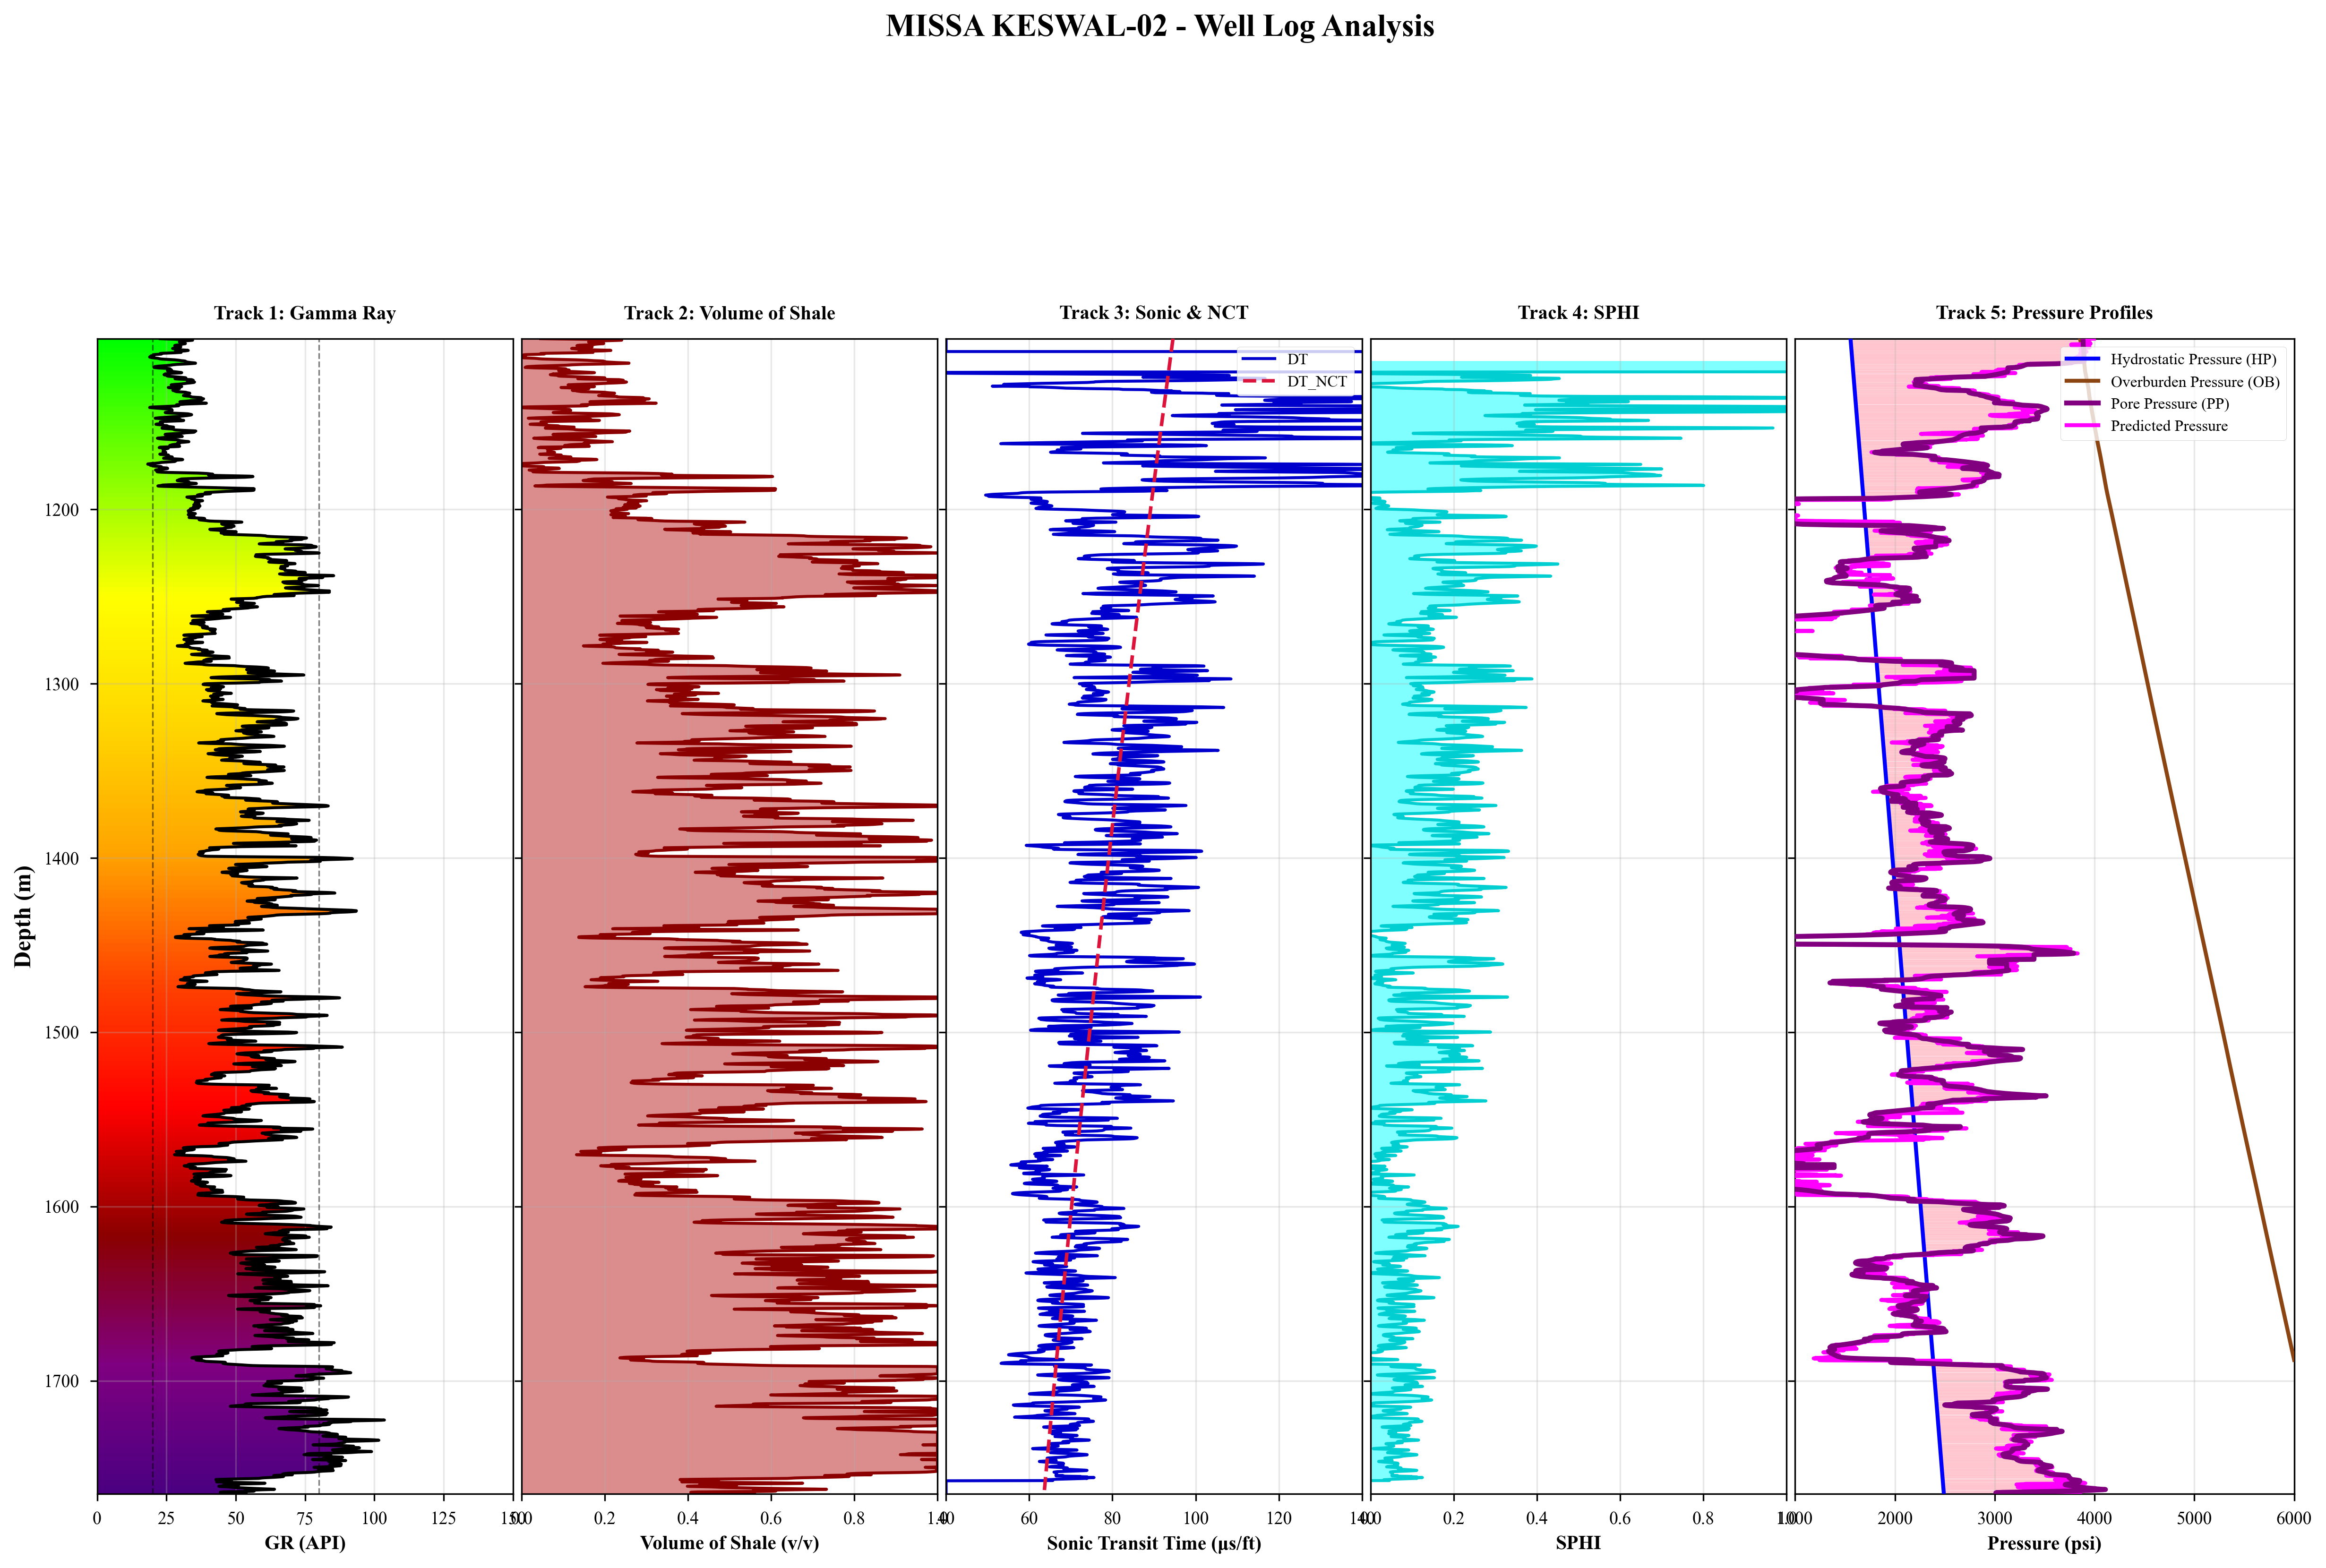


Well: MISSA KESWAL-02
Depth range: 1102.0 - 1764.8 m
Number of data points: 4500

Pressure statistics:
  Hydrostatic: 1555.4 - 2490.3 psi
  Pore Pressure: 136.4 - 4109.7 psi
  Overburden: 3854.4 - 6295.7 psi
  Predicted: 253.0 - 4021.5 psi

Pressure zone analysis:
  Overpressure zones: 3072 (68.3%)
  Normal/Underpressure zones: 1428 (31.7%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection




if 'well' in df_val.columns or 'well_name' in df_val.columns:
    well_column = 'well' if 'well' in df_val.columns else 'well_name'
    print("Available wells:", df_val[well_column].unique())
    
   
    target_well = df_val[well_column].unique()[0]  
    df_well = df_val[df_val[well_column] == target_well].copy()
    
    
    well_indices = df_val[df_val[well_column] == target_well].index
    well_predictions = y_pred_stacking[well_indices]
    well_name = target_well
else:
    df_well = df_val.copy()
    well_predictions = y_pred_stacking
    well_name = "MISSA KESWAL-02"

# Create combined dataframe and sort by depth
df_well['predicted_pressure'] = well_predictions
df_well_sorted = df_well.sort_values('depth').reset_index(drop=True)

# Calculate Volume of Shale (Vsh) from GR 
if 'vsh' not in df_well_sorted.columns:
    gr_clean = 20  
    gr_shale = 80  
    df_well_sorted['vsh'] = (df_well_sorted['gr'] - gr_clean) / (gr_shale - gr_clean)
    df_well_sorted['vsh'] = df_well_sorted['vsh'].clip(0, 1)

# Extract data for plotting
depth = df_well_sorted['depth'].values

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(2, 5, height_ratios=[0.05, 1], width_ratios=[1, 1, 1, 1, 1.2], wspace=0.02, hspace=0.3)

# Create custom colormap for GR
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


colors = ['#00FF00',   # Bright green (low GR - clean sand)
          '#7FFF00',   # Chartreuse
          '#FFFF00',   # Yellow
          '#FFD700',   # Gold
          '#FFA500',   # Orange
          '#FF4500',   # Orange red
          '#FF0000',   # Red
          '#8B0000',   # Dark red
          '#800080',   # Purple (high GR - shale)
          '#4B0082']   # Indigo

n_bins = 256  # Increase bins for smoother gradient
cmap_name = 'gr_lithology'
gr_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Clear all top row cells 
for i in range(5):
    ax_temp = fig.add_subplot(gs[0, i])
    ax_temp.axis('off')

# Set common depth range
depth_min, depth_max = depth.min(), depth.max()

# Track 1: Gamma Ray with multi-color fill - VERTICAL GRADIENT BY DEPTH
ax1 = fig.add_subplot(gs[1, 0])
gr = df_well_sorted['gr'].values

# Create a vertical gradient background
# Create a 2D array where values change only vertically (with depth)
n_depth_steps = 1000  # High resolution for smooth gradient
depth_array = np.linspace(depth_min, depth_max, n_depth_steps)
depth_normalized = (depth_array - depth_min) / (depth_max - depth_min)

# Create 2D array for the gradient (constant horizontally, varies vertically)
gradient_2d = np.tile(depth_normalized.reshape(-1, 1), (1, 2))

# Display the vertical gradient
gradient_image = ax1.imshow(gradient_2d, extent=[0, 150, depth_max, depth_min], 
                           aspect='auto', cmap=gr_cmap, alpha=1.0, zorder=1)

# Create a polygon to mask the gradient to only show it within the GR curve
from matplotlib.patches import Polygon
vertices = []
# Add points along the GR curve
for i in range(len(depth)):
    vertices.append((gr[i], depth[i]))
# Add points along the left edge (x=0) in reverse order
for i in range(len(depth)-1, -1, -1):
    vertices.append((0, depth[i]))

# Create and add the polygon patch as a clip path
poly = Polygon(vertices, closed=True, facecolor='none', edgecolor='none')
ax1.add_patch(poly)
gradient_image.set_clip_path(poly)

# Plot GR curve - black line on top
ax1.plot(gr, depth, color='black', linewidth=1.5, zorder=3)

gr_clean = 20
gr_shale = 80

ax1.set_xlim(0, 150)
ax1.set_ylim(depth_max, depth_min)
ax1.set_xlabel('GR (API)', fontsize=10, fontweight='bold')
ax1.set_ylabel('Depth (m)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, zorder=2)
ax1.set_title('Track 1: Gamma Ray', fontsize=10, fontweight='bold', pad=10)
ax1.axvline(x=gr_clean, color='black', linestyle='--', alpha=0.5, linewidth=0.8, zorder=2)
ax1.axvline(x=gr_shale, color='black', linestyle='--', alpha=0.5, linewidth=0.8, zorder=2)

# Track 2: Volume of Shale
ax2 = fig.add_subplot(gs[1, 1])
vsh = df_well_sorted['vsh'].values

ax2.plot(vsh, depth, color='#8B0000', linewidth=1.5)  # Dark red
ax2.fill_betweenx(depth, 0, vsh, where=(vsh >= 0), interpolate=True, 
                  color='#CD5C5C', alpha=0.7)  # Indian red

ax2.set_xlim(0, 1)
ax2.set_ylim(depth_max, depth_min)
ax2.set_xlabel('Volume of Shale (v/v)', fontsize=10, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_title('Track 2: Volume of Shale', fontsize=10, fontweight='bold', pad=10)
ax2.set_yticklabels([])

# Track 3: Sonic & NCT
ax3 = fig.add_subplot(gs[1, 2])
dt = df_well_sorted['dt'].values
dt_nct = df_well_sorted['dt_nct'].values

# Plot sonic curves - matching reference colors
ax3.plot(dt, depth, color='#0000CD', linewidth=1.5, label='DT', zorder=2)  # Medium blue
ax3.plot(dt_nct, depth, color='#DC143C', linewidth=1.8, label='DT_NCT', linestyle='--', zorder=3)  # Crimson

ax3.set_xlim(40, 140)
ax3.set_ylim(depth_max, depth_min)
ax3.set_xlabel('Sonic Transit Time (μs/ft)', fontsize=10, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_title('Track 3: Sonic & NCT', fontsize=10, fontweight='bold', pad=10)
ax3.legend(loc='upper right', fontsize=8)
ax3.set_yticklabels([])

# Track 4: Neutron Porosity (SPHI) - UPDATED SCALE
ax4 = fig.add_subplot(gs[1, 3])


if 'sphi' in df_well_sorted.columns:
    sphi = df_well_sorted['sphi'].values
    ax4.plot(sphi, depth, color='#00CED1', linewidth=1.5)  # Dark turquoise
    ax4.fill_betweenx(depth, 0, sphi, where=(sphi >= 0), interpolate=True,
                      color='#00FFFF', alpha=0.5)  # Cyan
else:
    
    ax4.text(0.5, (depth_min + depth_max) / 2, 'SPHI Data Not Available', 
             rotation=90, va='center', ha='center', fontsize=12, color='gray')

# UPDATED: Set SPHI scale to 0-1
ax4.set_xlim(0, 1)
ax4.set_ylim(depth_max, depth_min)
ax4.set_xlabel('SPHI', fontsize=10, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_title('Track 4: SPHI', fontsize=10, fontweight='bold', pad=10)
ax4.set_yticklabels([])

# Track 5: Pressure Profiles
ax5 = fig.add_subplot(gs[1, 4])

# Extract pressure data
hp = df_well_sorted['hp'].values
ob = df_well_sorted['ob'].values
ppp = df_well_sorted['ppp'].values
predicted_pressure = df_well_sorted['predicted_pressure'].values

# FIRST: Add shading for over/under pressure zones - matching reference colors
for i in range(len(depth)-1):
    if ppp[i] > hp[i]:  # Overpressure
        ax5.fill_betweenx([depth[i], depth[i+1]], hp[i], ppp[i], 
                          color='#FFB6C1', alpha=0.3, zorder=1)  # Light pink
    # No shading for underpressure in reference image


ax5.plot(hp, depth, color='#0000FF', linewidth=2, label='Hydrostatic Pressure (HP)', zorder=3)  # Blue
ax5.plot(ob, depth, color='#8B4513', linewidth=2, label='Overburden Pressure (OB)', zorder=3)  # Saddle brown
ax5.plot(ppp, depth, color='#800080', linewidth=2.5, label='Pore Pressure (PP)', zorder=4)  # Purple
ax5.plot(predicted_pressure, depth, color='#FF00FF', linewidth=2, 
         label='Predicted Pressure', linestyle='-', zorder=3)  # Magenta

# Set pressure limits with some margin
pressure_min = min(hp.min(), ppp.min(), predicted_pressure.min()) * 0.95
pressure_max = ob.max() * 1.05
ax5.set_xlim(1000, 6000)  # Fixed range as in reference
ax5.set_ylim(depth_max, depth_min)
ax5.set_xlabel('Pressure (psi)', fontsize=10, fontweight='bold')
ax5.grid(True, alpha=0.3, zorder=0)
ax5.set_title('Track 5: Pressure Profiles', fontsize=10, fontweight='bold', pad=10)

# Add legend matching reference style
ax5.legend(loc='upper right', fontsize=8)
ax5.set_yticklabels([])

# Add main title
fig.suptitle(f'{well_name} - Well Log Analysis', fontsize=16, fontweight='bold', y=0.98)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.3)

# Show the plot
plt.show()

# Print some statistics
print(f"\nWell: {well_name}")
print(f"Depth range: {depth_min:.1f} - {depth_max:.1f} m")
print(f"Number of data points: {len(depth)}")
print(f"\nPressure statistics:")
print(f"  Hydrostatic: {hp.min():.1f} - {hp.max():.1f} psi")
print(f"  Pore Pressure: {ppp.min():.1f} - {ppp.max():.1f} psi")
print(f"  Overburden: {ob.min():.1f} - {ob.max():.1f} psi")
print(f"  Predicted: {predicted_pressure.min():.1f} - {predicted_pressure.max():.1f} psi")

# Calculate overpressure zones
overpressure_count = np.sum(ppp > hp)
normal_pressure_count = np.sum(ppp <= hp)

print(f"\nPressure zone analysis:")
print(f"  Overpressure zones: {overpressure_count} ({overpressure_count/len(depth)*100:.1f}%)")
print(f"  Normal/Underpressure zones: {normal_pressure_count} ({normal_pressure_count/len(depth)*100:.1f}%)")